# 0. INTRODUCCIÓN

Vamos a hacer un análisis de los datos en un proceso de fabricación del acero por medio de Horno de Arco Eléctrico (EAF).

También trataré de hacer un análisis predictivo de la composición final del acero en función de los parámetros del proceso.

Los datos han sido sacados de la fuente Kaggle, concretamente este dataset:
https://www.kaggle.com/datasets/yuriykatser/industrial-data-from-the-arc-furnace

In [319]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import matplotlib.ticker as mtick
import random

In [154]:
cesto = pd.read_csv('basket_charged.csv', dtype={4: 'str'})
horno = pd.read_csv('eaf_added_materials.csv')
carbono = pd.read_csv('inj_mat.csv')
oxigeno = pd.read_csv('eaf_gaslance_mat.csv')
cesto2 = pd.read_csv('ladle_tapping.csv')
cuchara = pd.read_csv('lf_added_materials.csv')
trafo = pd.read_csv('eaf_transformer.csv')
temp = pd.read_csv('eaf_temp.csv')
inicial = pd.read_csv('lf_initial_chemical_measurements.csv')
final = pd.read_csv('eaf_final_chemical_measurements.csv')
ferro = pd.read_csv('ferro.csv')

# 1. LIMPIEZA DE DATOS

## Problemas de carga de datos

Como ha habido un error al cargar el dataframe "cesto" por contener tipos de valores mezclados en la columna 4, vamos a observar primero qué valores dan el problema

In [158]:
cesto.dtypes

MAT_CODE           int64
MAT_DEC           object
HEATID            object
DATETIME          object
CHARGED_AMOUNT    object
dtype: object

Vemos que la columna 4 tiene los valores de la cantidad en peso de materiales añadidos al horno. Los valores de esta columna deberían ser de tipo numérico `float`.

Por tanto, vamos a averiguar qué valores dan el problema y por qué.

In [160]:
def detectar_problemas(valor):
    try:
        # Intenta convertir a tipo numérico
        float(valor)
        return False  # Si puede convertir, no es un problema
    except ValueError:
        return True  # Si falla, es un problema de tipo

filas_problema = cesto[cesto['CHARGED_AMOUNT'].apply(detectar_problemas)]
filas_problema

,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGED_AMOUNT
10996,601025,25A1,6F1646,2016-03-09 16:28:00,"9954,4"
11010,601025,25A1,6F1647,2016-03-09 17:29:00,"9006,8"
11016,601025,25A1,6F1648,2016-03-09 18:34:00,"14204,8"
11021,601025,25A1,6F1649,2016-03-09 19:21:00,"13450,4"
11040,601025,25A1,6F1651,2016-03-09 21:13:00,"8307,6"
...,...,...,...,...,...
114875,205180,16A,5F4435,2015-07-02 11:11:00,"6030,5"
114884,205180,16A,5F4436,2015-07-02 12:00:00,"6700,2"
114890,205180,16A,5F4437,2015-07-02 12:49:00,"4700,2"
114894,205180,16A,5F4438,2015-07-02 13:49:00,"5360,8"


El problema viene por la coma, la cambiamos por '.'

In [162]:
cesto['CHARGED_AMOUNT'] = cesto['CHARGED_AMOUNT'].str.replace(',', '.')

## Formato de datos

Convertimos los datos de las tablas a su formato deseado

In [165]:
# Guardar todas las tablas en un diccionario
dataframes = {
    'Cesto': cesto,
    'Horno': horno,
    'Carbono': carbono,
    'Oxigeno': oxigeno,
    'Cesto2': cesto2,
    'Cuchara': cuchara,
    'Trafo': trafo,
    'Temp': temp,
    'Inicial': inicial,
    'Final': final,
    'Ferro': ferro
}

# Mostrar las primeras 3 filas de cada tabla
for name, df in dataframes.items():
    print(f"\n{name}:")
    print(df.head(3))


Cesto:
   MAT_CODE                 MAT_DEC  HEATID             DATETIME  \
0    205051                      3A  6F0020  2016-01-01 18:51:00   
1    205051                      3A  6F0020  2016-01-01 19:24:00   
2    360258  In-house produced lime  6F0020  2016-01-01 18:33:00   

  CHARGED_AMOUNT  
0          54071  
1          75240  
2           2502  

Horno:
   MAT_CODE        MAT_DEC  HEATID             DATETIME CHARGE_AMOUNT
0    705046        FOMI B2  6F0020  2016-01-01 19:10:00           723
1    203068  Coke 10-30 mm  6F0020  2016-01-01 19:10:00           517
2    705043          Magma  6F0020  2016-01-01 19:10:00           705

Carbono:
                   REVTIME INJ_AMOUNT_CARBON INJ_FLOW_CARBON  HEATID
0  2016-01-01 18:31:45,972              0,00           0,000  6F0020
1  2016-01-01 18:31:55,925              0,00           0,000  6F0020
2  2016-01-01 18:32:55,956              0,00           0,000  6F0020

Oxigeno:
                   REVTIME O2_AMOUNT GAS_AMOUNT O2_FLOW GAS

In [166]:
# 1. Convertir 'DATETIME' a formato datetime
cesto['DATETIME'] = pd.to_datetime(cesto['DATETIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# 2. 'CHARGED_AMOUNT' convertir a float
cesto['CHARGED_AMOUNT'] = cesto['CHARGED_AMOUNT'].astype(float)

cesto.dtypes

MAT_CODE                   int64
MAT_DEC                   object
HEATID                    object
DATETIME          datetime64[ns]
CHARGED_AMOUNT           float64
dtype: object

In [167]:
horno.dtypes

MAT_CODE          int64
MAT_DEC          object
HEATID           object
DATETIME         object
CHARGE_AMOUNT    object
dtype: object

En el caso de los datos de los materiales en el horno, las comas también deberían estar como '.', así que lo cambiamos antes de formatearlo

In [169]:
# 1. Convertir 'DATETIME' a formato datetime
horno['DATETIME'] = pd.to_datetime(horno['DATETIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# 2. 'CHARGED_AMOUNT' convertir a float
horno['CHARGE_AMOUNT'] = horno['CHARGE_AMOUNT'].str.replace(',', '.').astype(float)

horno.dtypes

MAT_CODE                  int64
MAT_DEC                  object
HEATID                   object
DATETIME         datetime64[ns]
CHARGE_AMOUNT           float64
dtype: object

In [170]:
carbono.dtypes

REVTIME              object
INJ_AMOUNT_CARBON    object
INJ_FLOW_CARBON      object
HEATID               object
dtype: object

In [171]:
# 1. Convertir la inyección y el flow de carbono a formato float
carbono['INJ_AMOUNT_CARBON'] = carbono['INJ_AMOUNT_CARBON'].str.replace(',', '.').astype(float)
carbono['INJ_FLOW_CARBON'] = carbono['INJ_FLOW_CARBON'].str.replace(',', '.').astype(float)

carbono.dtypes

REVTIME               object
INJ_AMOUNT_CARBON    float64
INJ_FLOW_CARBON      float64
HEATID                object
dtype: object

Ahora tenemos que cambiar el formato de la fecha y hora, pero en los segundos de la hora tiene comas. Primero hay que resolver esto

In [173]:
carbono['REVTIME'] = carbono['REVTIME'].str.replace(',', '.')
carbono['REVTIME'] = pd.to_datetime(carbono['REVTIME'])

carbono.dtypes

REVTIME              datetime64[ns]
INJ_AMOUNT_CARBON           float64
INJ_FLOW_CARBON             float64
HEATID                       object
dtype: object

In [174]:
oxigeno.dtypes

REVTIME       object
O2_AMOUNT     object
GAS_AMOUNT    object
O2_FLOW       object
GAS_FLOW      object
HEATID        object
dtype: object

In [175]:
oxigeno['REVTIME'] = oxigeno['REVTIME'].str.replace(',', '.')
oxigeno['REVTIME'] = pd.to_datetime(oxigeno['REVTIME'])
oxigeno['O2_AMOUNT'] = oxigeno['O2_AMOUNT'].str.replace(',', '.').astype(float)
oxigeno['GAS_AMOUNT'] = oxigeno['GAS_AMOUNT'].str.replace(',', '.').astype(float)
oxigeno['O2_FLOW'] = oxigeno['O2_FLOW'].str.replace(',', '.').astype(float)
oxigeno['GAS_FLOW'] = oxigeno['GAS_FLOW'].str.replace(',', '.').astype(float)

oxigeno.dtypes

REVTIME       datetime64[ns]
O2_AMOUNT            float64
GAS_AMOUNT           float64
O2_FLOW              float64
GAS_FLOW             float64
HEATID                object
dtype: object

In [176]:
cesto2.dtypes

HEATID           object
MAT_CODE          int64
MAT_DEC          object
CHARGE_AMOUNT    object
DATETIME         object
dtype: object

In [177]:
cesto2['DATETIME'] = pd.to_datetime(cesto2['DATETIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
cesto2['CHARGE_AMOUNT'] = cesto2['CHARGE_AMOUNT'].str.replace(',', '.').astype(float)

cesto2.dtypes

HEATID                   object
MAT_CODE                  int64
MAT_DEC                  object
CHARGE_AMOUNT           float64
DATETIME         datetime64[ns]
dtype: object

In [178]:
cuchara.dtypes

FILTER_KEY_DATE    object
HEATID             object
MAT_CODE            int64
DESCR              object
MAT_CHARGED        object
dtype: object

In [179]:
cuchara['FILTER_KEY_DATE'] = pd.to_datetime(cuchara['FILTER_KEY_DATE'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
cuchara['MAT_CHARGED'] = cuchara['MAT_CHARGED'].str.replace(',', '.').astype(float)

cuchara.dtypes

FILTER_KEY_DATE    datetime64[ns]
HEATID                     object
MAT_CODE                    int64
DESCR                      object
MAT_CHARGED               float64
dtype: object

In [180]:
trafo.dtypes

TAP           int64
HEATID       object
STARTTIME    object
DURATION     object
MW           object
dtype: object

In [181]:
trafo['STARTTIME'] = pd.to_datetime(trafo['STARTTIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
trafo['MW'] = trafo['MW'].str.replace(',', '.').astype(float)

#Cambiamos la duración a formato tiempo en minutos:segundos
#Para ello primero tenemos que eliminar el espacio entre los dos puntos y los segundos
trafo['DURATION'] = trafo['DURATION'].str.replace(' ', '')

#La funcion timedelta puede servir, pero por defecto usa horas:minutos
#Hay que indicarle que son minutos:segundos
def convert_to_timedelta(duracion):
    # Dividir el string en minutos y segundos
    minutes, seconds = duracion.split(':')
    # Convertir a Timedelta
    return pd.Timedelta(minutes=int(minutes), seconds=int(seconds))

# Aplicar la función a la columna 'duracion'
trafo['DURATION'] = trafo['DURATION'].apply(convert_to_timedelta)

trafo.dtypes

TAP                    int64
HEATID                object
STARTTIME     datetime64[ns]
DURATION     timedelta64[ns]
MW                   float64
dtype: object

In [182]:
temp.dtypes

HEATID        object
DATETIME      object
TEMP         float64
VALO2_PPM    float64
dtype: object

In [183]:
temp['DATETIME'] = pd.to_datetime(temp['DATETIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

temp.dtypes

HEATID               object
DATETIME     datetime64[ns]
TEMP                float64
VALO2_PPM           float64
dtype: object

In [184]:
inicial.dtypes

HEATID         object
POSITIONROW     int64
DATETIME       object
VALC           object
VALSI          object
VALMN          object
VALP           object
VALS           object
VALCU          object
VALCR          object
VALMO          object
VALNI          object
dtype: object

Aqui tendremos que cambiar muchas columnas. Todas las que empiezan por "VAL" deben ser tipo `float` y se debe cambiar la coma por un punto para que se interprete correctamente. Como son muchas columnas, lo haremos con un bucle

In [186]:
#Cambiar formato de fecha
inicial['DATETIME'] = pd.to_datetime(inicial['DATETIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

#Formatos float
# 1. Identificar las columnas que comienzan con 'VAL'
val_columns = [col for col in inicial.columns if col.startswith('VAL')]

# 2. Reemplazar las comas por puntos y convertir a float
for col in val_columns:
    inicial[col] = inicial[col].str.replace(',', '.').astype(float)  # Reemplazar comas por puntos y convertir a float

inicial.dtypes

HEATID                 object
POSITIONROW             int64
DATETIME       datetime64[ns]
VALC                  float64
VALSI                 float64
VALMN                 float64
VALP                  float64
VALS                  float64
VALCU                 float64
VALCR                 float64
VALMO                 float64
VALNI                 float64
dtype: object

In [187]:
final.dtypes

HEATID         object
POSITIONROW     int64
DATETIME       object
VALC           object
VALSI          object
VALMN          object
VALP           object
VALS           object
VALCU          object
VALCR          object
VALMO          object
VALNI          object
VALAS          object
VALSN          object
VALN           object
dtype: object

Ocurre lo mismo que con el dataframe anterior. Cambiamos varias columnas a la vez con un bucle

In [189]:
#Cambiar formato de fecha
final['DATETIME'] = pd.to_datetime(final['DATETIME'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

#Formatos float
# 1. Identificar las columnas que comienzan con 'VAL'
val_columns = [col for col in final.columns if col.startswith('VAL')]

# 2. Reemplazar las comas por puntos y convertir a float
for col in val_columns:
    final[col] = final[col].str.replace(',', '.').astype(float)  # Reemplazar comas por puntos y convertir a float

final.dtypes

HEATID                 object
POSITIONROW             int64
DATETIME       datetime64[ns]
VALC                  float64
VALSI                 float64
VALMN                 float64
VALP                  float64
VALS                  float64
VALCU                 float64
VALCR                 float64
VALMO                 float64
VALNI                 float64
VALAS                 float64
VALSN                 float64
VALN                  float64
dtype: object

In [190]:
ferro.dtypes

Unnamed: 0       int64
Description     object
Slagging         int64
Nb             float64
Ta             float64
Mo             float64
V              float64
Ca             float64
Al             float64
Mg             float64
P              float64
S              float64
Ash            float64
Moisture       float64
C              float64
Si             float64
Mn             float64
Cr             float64
Ti             float64
Cu             float64
Zn             float64
Ni             float64
Pb             float64
Sn             float64
Al2O3          float64
CaO+MgO        float64
CaO            float64
SiO2           float64
MgO            float64
FeO            float64
Fe2O3          float64
Cr2O3          float64
TiO2           float64
Na+K           float64
TiO            float64
As             float64
SiC            float64
Zr             float64
MAT_CODE         int64
dtype: object

En esta ultima tabla de `ferro`, que contiene la composicion de los materiales, no hay que hacer ningún cambio de formato en ninguna columna

## Gestion de datos nulos

In [193]:
cesto.isnull().sum()

MAT_CODE          0
MAT_DEC           0
HEATID            0
DATETIME          0
CHARGED_AMOUNT    0
dtype: int64

In [194]:
horno.isnull().sum()

MAT_CODE         0
MAT_DEC          0
HEATID           0
DATETIME         0
CHARGE_AMOUNT    0
dtype: int64

In [195]:
cuchara.isnull().sum()

FILTER_KEY_DATE    0
HEATID             0
MAT_CODE           0
DESCR              0
MAT_CHARGED        0
dtype: int64

In [196]:
trafo.isnull().sum()

TAP          0
HEATID       0
STARTTIME    0
DURATION     0
MW           0
dtype: int64

In [197]:
temp.isnull().sum()

HEATID       0
DATETIME     0
TEMP         0
VALO2_PPM    0
dtype: int64

In [198]:
inicial.isnull().sum()

HEATID         0
POSITIONROW    0
DATETIME       0
VALC           0
VALSI          0
VALMN          0
VALP           0
VALS           0
VALCU          0
VALCR          0
VALMO          0
VALNI          0
dtype: int64

In [199]:
ferro.isnull().sum()

Unnamed: 0     0
Description    0
Slagging       0
Nb             0
Ta             0
Mo             0
V              0
Ca             0
Al             0
Mg             0
P              0
S              0
Ash            0
Moisture       0
C              0
Si             0
Mn             0
Cr             0
Ti             0
Cu             0
Zn             0
Ni             0
Pb             0
Sn             0
Al2O3          0
CaO+MgO        0
CaO            0
SiO2           0
MgO            0
FeO            0
Fe2O3          0
Cr2O3          0
TiO2           0
Na+K           0
TiO            0
As             0
SiC            0
Zr             0
MAT_CODE       0
dtype: int64

In [200]:
carbono.isnull().sum()

REVTIME              0
INJ_AMOUNT_CARBON    0
INJ_FLOW_CARBON      0
HEATID               0
dtype: int64

In [201]:
oxigeno.isnull().sum()

REVTIME       0
O2_AMOUNT     0
GAS_AMOUNT    1
O2_FLOW       0
GAS_FLOW      0
HEATID        0
dtype: int64

In [202]:
cesto2.isnull().sum()

HEATID             0
MAT_CODE           0
MAT_DEC            0
CHARGE_AMOUNT      0
DATETIME         310
dtype: int64

In [203]:
final.isnull().sum()

HEATID            0
POSITIONROW       0
DATETIME          0
VALC            368
VALSI           368
VALMN           368
VALP            369
VALS            368
VALCU           368
VALCR           368
VALMO           368
VALNI           368
VALAS           368
VALSN           369
VALN           1292
dtype: int64

Tenemos 3 tablas que tienen valores nulos. Vamos a ver cuáles son para decidir qué hacer con ellos

In [205]:
oxigeno[oxigeno['GAS_AMOUNT'].isnull()]

,REVTIME,O2_AMOUNT,GAS_AMOUNT,O2_FLOW,GAS_FLOW,HEATID
4993520,2015-08-04 14:33:25.500,0.0,NaN,0.0,0.0,5F5201


Es solo una fila, y el resto de valores son 0, así que esa fila no nos da mucha información y hacemos más daño estimándola que quitándola. Vamos a eliminarla

In [207]:
oxigeno = oxigeno.dropna(subset=['GAS_AMOUNT'])
oxigeno.isnull().sum()

REVTIME       0
O2_AMOUNT     0
GAS_AMOUNT    0
O2_FLOW       0
GAS_FLOW      0
HEATID        0
dtype: int64

In [208]:
nulos_fecha = cesto2[cesto2['DATETIME'].isnull()]
nulos_fecha

,HEATID,MAT_CODE,MAT_DEC,CHARGE_AMOUNT,DATETIME
377,6F0096,202007,MnSi17A,0.0,NaT
388,6F0098,202007,MnSi17A,0.0,NaT
802,6F0169,202007,MnSi17A,0.0,NaT
871,6F0183,202007,MnSi17A,0.0,NaT
877,6F0185,202007,MnSi17A,0.0,NaT
...,...,...,...,...,...
114641,5F8214,202007,MnSi17A,0.0,NaT
114654,5F8216,202007,MnSi17A,0.0,NaT
114712,5F8226,202007,MnSi17A,0.0,NaT
114823,5F8246,202007,MnSi17A,0.0,NaT


Voy a comprobar si todos los que tienen fecha nula también tienen `CHARGE_AMOUNT` = 0

In [210]:
(nulos_fecha['CHARGE_AMOUNT'] == 0).all()

True

Como todos tienen valor cero en la cantidad de carga, podemos prescindir de ellos, ya que no nos aportan ninguna información

In [212]:
cesto2 = cesto2.dropna(subset=['DATETIME'])
cesto2.isnull().sum()

HEATID           0
MAT_CODE         0
MAT_DEC          0
CHARGE_AMOUNT    0
DATETIME         0
dtype: int64

In [213]:
final[final['VALC'].isnull()]

,HEATID,POSITIONROW,DATETIME,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,VALAS,VALSN,VALN
238,6F2467,1,2016-04-11 20:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,6F2597,1,2016-04-16 20:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,6F2718,1,2016-04-24 22:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,6F2791,1,2016-04-27 15:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,6F4248,1,2016-06-26 13:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,5F6947,1,2015-10-31 21:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3614,5F7004,1,2015-11-03 12:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,5F7380,1,2015-11-19 09:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3654,5F7619,1,2015-11-28 23:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Parece que cuando el dato es nulo, es nulo para todas las columnas, así que podemos eliminar todas las filas en las que todos los valores sean nulos

In [215]:
# Seleccionar las columnas que comienzan con 'VAL'
val_columns = [col for col in final.columns if col.startswith('VAL')]

# Filtrar para mantener solo las filas donde al menos una columna 'VAL' no es nula
final = final.dropna(subset=val_columns, how='all')

final.isnull().sum()

HEATID           0
POSITIONROW      0
DATETIME         0
VALC             0
VALSI            0
VALMN            0
VALP             1
VALS             0
VALCU            0
VALCR            0
VALMO            0
VALNI            0
VALAS            0
VALSN            1
VALN           924
dtype: int64

Ahora estimamos los dos nulos de VALP y VALSN. Primero, vemos sus distribuciones de valores, y después, si tienen correlación con otros elementos

<Axes: xlabel='VALP', ylabel='Count'>

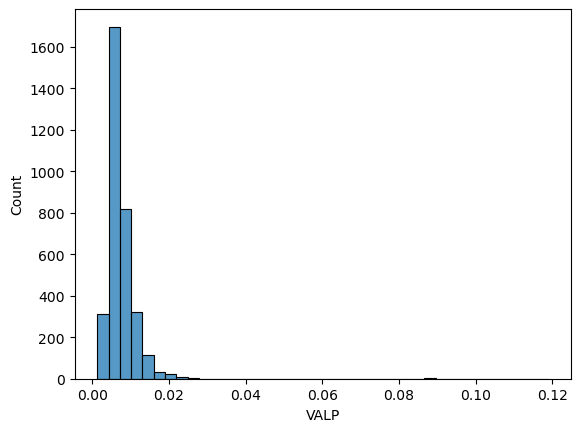

In [217]:
sns.histplot(data=final, x='VALP', bins=40, kde=False)

<Axes: xlabel='VALSN', ylabel='Count'>

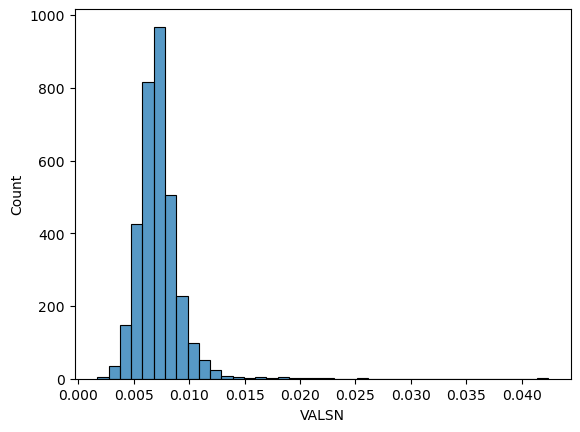

In [218]:
sns.histplot(data=final, x='VALSN', bins=40, kde=False)

In [219]:
final[final['VALP'].isnull()]

,HEATID,POSITIONROW,DATETIME,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,VALAS,VALSN,VALN
1291,7F6648,1,2017-10-04 09:39:00,0.0942,0.0524,0.1137,NaN,0.0299,0.1535,0.0653,0.0227,0.1112,0.0078,0.0083,3.3197


In [220]:
data_without_nulls = final[final['VALP'].notnull()]

In [221]:
# Calcular la matriz de correlación
correlation_matrix = data_without_nulls.loc[:, data_without_nulls.columns.str.startswith('VAL')].corr()

# Ver la correlación de VALP con otras columnas
valp_correlations = correlation_matrix['VALP']
valp_correlations

VALC     0.016227
VALSI    0.109995
VALMN    0.262196
VALP     1.000000
VALS     0.458571
VALCU    0.117276
VALCR    0.307662
VALMO    0.047874
VALNI   -0.014668
VALAS    0.133974
VALSN    0.070697
VALN    -0.020411
Name: VALP, dtype: float64

No hay correlacion muy grande, asi que lo estimamos con la mediana, para VALP y para VALSN

In [223]:
final['VALP'] = final['VALP'].fillna(final['VALP'].median())
final['VALSN'] = final['VALSN'].fillna(final['VALSN'].median())

final.isnull().sum()

C:\Users\lucia\AppData\Local\Temp\ipykernel_15104\1523473635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['VALP'] = final['VALP'].fillna(final['VALP'].median())
C:\Users\lucia\AppData\Local\Temp\ipykernel_15104\1523473635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['VALSN'] = final['VALSN'].fillna(final['VALSN'].median())


HEATID           0
POSITIONROW      0
DATETIME         0
VALC             0
VALSI            0
VALMN            0
VALP             0
VALS             0
VALCU            0
VALCR            0
VALMO            0
VALNI            0
VALAS            0
VALSN            0
VALN           924
dtype: int64

Ahora solo quedan nulos en VALN

In [225]:
final[final['VALN'].isnull()]

,HEATID,POSITIONROW,DATETIME,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,VALAS,VALSN,VALN
80,6F0760,1,2016-02-02 18:59:00,0.0417,0.0175,0.0781,0.0050,0.0150,0.2100,0.0394,0.0163,0.1334,0.0062,0.0071,NaN
204,6F2167,1,2016-03-30 04:17:00,0.0686,0.0187,0.0649,0.0056,0.0305,0.1755,0.0676,0.0148,0.1216,0.0059,0.0057,NaN
208,6F2172,1,2016-03-30 09:01:00,0.0587,0.0176,0.0575,0.0039,0.0219,0.1701,0.0349,0.0131,0.1175,0.0075,0.0071,NaN
212,6F2177,1,2016-03-30 13:46:00,0.0568,0.0165,0.0591,0.0046,0.0214,0.1794,0.0444,0.0137,0.1046,0.0053,0.0054,NaN
265,6F2760,1,2016-04-26 10:22:00,0.0562,0.0194,0.0764,0.0046,0.0187,0.1749,0.0503,0.0115,0.1120,0.0065,0.0056,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3524,5F6286,1,2015-09-23 23:41:00,0.0772,0.0181,0.0861,0.0049,0.0228,0.2203,0.0605,0.0156,0.1303,0.0067,0.0086,NaN
3525,5F6290,1,2015-09-24 03:20:00,0.0514,0.0185,0.0908,0.0048,0.0210,0.1835,0.0805,0.0403,0.1728,0.0058,0.0057,NaN
3526,5F6292,1,2015-09-24 05:03:00,0.0725,0.0181,0.0960,0.0049,0.0296,0.1987,0.0728,0.0197,0.1427,0.0069,0.0089,NaN
3560,5F6537,1,2015-10-05 22:19:00,0.0865,0.0164,0.1112,0.0027,0.0205,0.1565,0.0681,0.0095,0.1019,0.0050,0.0056,NaN


In [226]:
final['VALN'].mean()

0.01373030864708316

In [227]:
data_without_nulls = final[final['VALN'].notnull()]

In [228]:
# Calcular la matriz de correlación
correlation_matrix = data_without_nulls.loc[:, data_without_nulls.columns.str.startswith('VAL')].corr()

# Ver la correlación de VALP con otras columnas
valp_correlations = correlation_matrix['VALN']
valp_correlations

VALC    -0.000872
VALSI    0.076601
VALMN    0.006560
VALP    -0.018428
VALS    -0.005218
VALCU   -0.008515
VALCR   -0.000168
VALMO   -0.000701
VALNI    0.014004
VALAS    0.049861
VALSN    0.012688
VALN     1.000000
Name: VALN, dtype: float64

El contenido en Nitrógeno tampoco tiene correlaciones claras.

Aquí hay que decidir si estimamos los valores de Nitrógeno en todas las filas que tienen valor nulo, o si por el contrario presncindimos de esas filas para conservar la integridad de los datos.

In [230]:
final.shape

(3341, 15)

En total tenemos unas 3341 filas. Si nos deshacemos de 924, estaríamos desechando más del 27% de los datos, lo cual es un porcentaje considerable

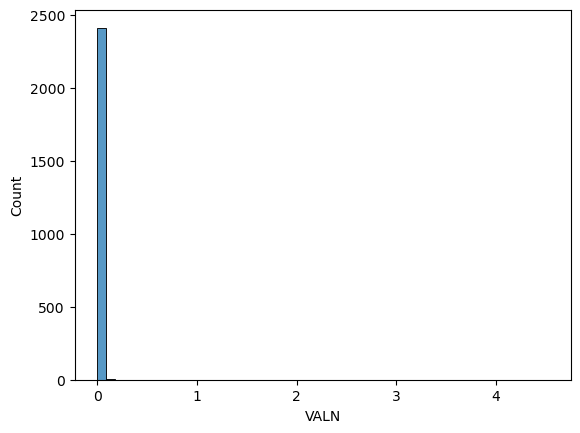

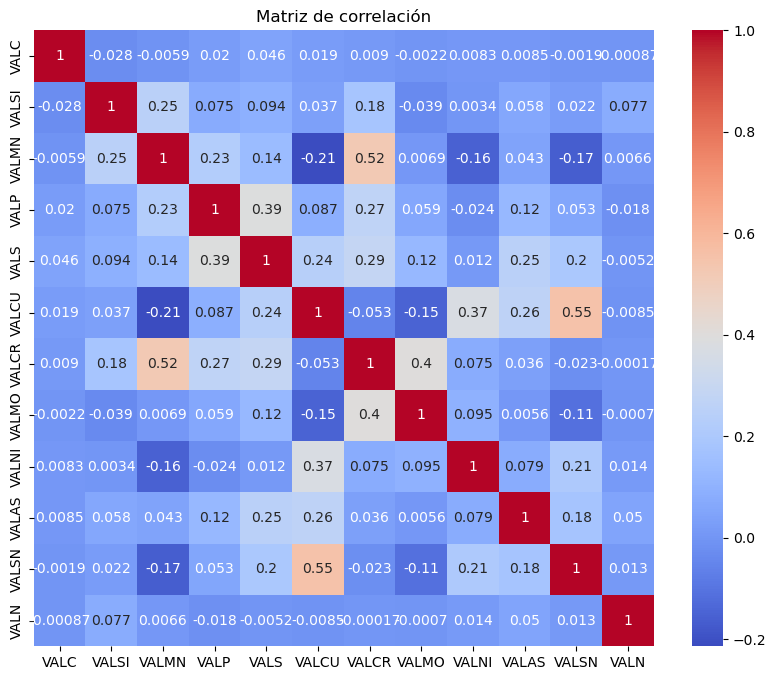

In [232]:
# Visualizar la distribución de la columna con nulos
sns.histplot(final['VALN'], bins=50, kde=False)
plt.show()

# Ver correlación con otras columnas
plt.figure(figsize=(10, 8))
correlaciones = data_without_nulls.loc[:, data_without_nulls.columns.str.startswith('VAL')].corr()
sns.heatmap(correlaciones, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

Nos damos cuenta de que en VALN hay valores anómalos altos. No los tendremos en cuenta para la estimación de los nulos y más adelante los corregiremos

<Axes: xlabel='VALN', ylabel='Count'>

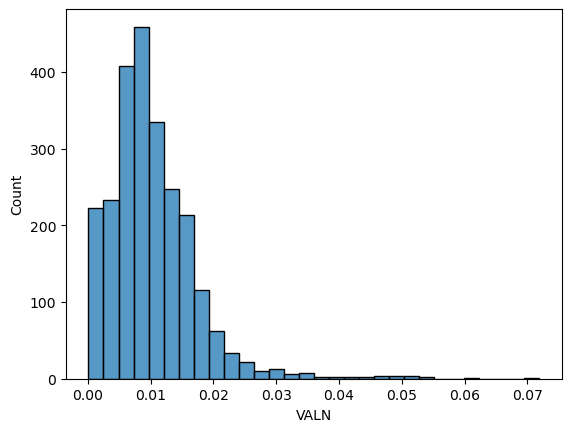

In [234]:
sns.histplot(final.loc[final['VALN']<0.1,'VALN'], bins=30, kde=False)

In [235]:
final.loc[final['VALN']>0.3,:]

,HEATID,POSITIONROW,DATETIME,VALC,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,VALAS,VALSN,VALN
1291,7F6648,1,2017-10-04 09:39:00,0.0942,0.0524,0.1137,0.0063,0.0299,0.1535,0.0653,0.0227,0.1112,0.0078,0.0083,3.3197
1791,8F2663,1,2018-04-07 22:26:00,0.1074,0.0366,0.1150,0.0013,0.0321,0.2008,0.0914,0.0226,0.1573,0.0081,0.0083,4.5249
2369,8F3847,1,2018-05-29 09:23:00,0.0804,0.0246,0.0891,0.0049,0.0290,0.1653,0.0921,0.0314,0.1608,0.0066,0.0077,0.4785


Estimamos los valores con la mediana de los valores NO anómalos

In [237]:
final['VALN'] = final['VALN'].fillna(final.loc[final['VALN'] < 0.1, 'VALN'].median())

final.isnull().sum()

C:\Users\lucia\AppData\Local\Temp\ipykernel_15104\978591819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['VALN'] = final['VALN'].fillna(final.loc[final['VALN'] < 0.1, 'VALN'].median())


HEATID         0
POSITIONROW    0
DATETIME       0
VALC           0
VALSI          0
VALMN          0
VALP           0
VALS           0
VALCU          0
VALCR          0
VALMO          0
VALNI          0
VALAS          0
VALSN          0
VALN           0
dtype: int64

Ya tenemos todos los valores nulos estimados!!

## Gestion de datos anómalos

Aquí gestionaremos los datos que parecen incongruentes, como por ejemplo, datos que por lógica no podrían ser negativos, etc.

### Negativos inesperados

Por ejemplo, en las tablas `cesto`, `horno`, `cesto2` y `cuchara`, la columna de cantidad añadida, debería tener valores solo positivos. Eliminaremos todas las filas cuyo valor sea cero porque no nos dan ninguna información, y observaremos los negativos para decidir

In [243]:
cesto.shape

(137685, 5)

In [244]:
cesto.describe()

,MAT_CODE,DATETIME,CHARGED_AMOUNT
count,137685.000000,137685,137685.000000
mean,260080.637230,2016-08-04 08:23:28.703780096,20318.667415
min,140107.000000,2015-01-01 00:51:00,-119200.000000
25%,205051.000000,2015-10-23 12:43:00,2502.000000
50%,205051.000000,2016-06-12 09:22:00,9920.000000
75%,360258.000000,2017-08-05 22:47:00,37107.000000
max,705059.000000,2018-07-29 08:49:00,135000.000000
std,112956.002774,NaN,22002.083043


In [245]:
cesto[cesto['CHARGED_AMOUNT']==0]

,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGED_AMOUNT
95818,360258,In-house produced lime,5F0595,2015-01-25 10:42:00,0.0
95823,360258,In-house produced lime,5F0595,2015-01-25 10:08:00,0.0
95830,360258,In-house produced lime,5F0596,2015-01-25 11:18:00,0.0
95869,205069,Secondary aluminum AV 87,5F0603,2015-01-25 17:56:00,0.0
100599,203068,Coke 10-30 mm,5F1764,2015-03-14 09:57:00,0.0
100765,203068,Coke 10-30 mm,5F1798,2015-03-15 09:58:00,0.0
101053,203068,Coke 10-30 mm,5F1853,2015-03-17 10:13:00,0.0
101088,203068,Coke 10-30 mm,5F1860,2015-03-17 09:57:00,0.0
102823,205051,3A,5F2231,2015-04-01 09:17:00,0.0
103161,202034,FeCr025,5F2289,2015-04-04 09:32:00,0.0


In [246]:
# Eliminar esas filas usando drop
cesto = cesto.drop(cesto[cesto['CHARGED_AMOUNT'] == 0].index)
cesto[cesto['CHARGED_AMOUNT']==0]

,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGED_AMOUNT


In [247]:
cesto[cesto['CHARGED_AMOUNT']<0].groupby('MAT_CODE')['CHARGED_AMOUNT'].sum().reset_index()

,MAT_CODE,CHARGED_AMOUNT
0,140107,-2222.0
1,140111,-1200.0
2,201003,-50480.0
3,201010,-36120.0
4,202002,-2.0
5,202007,-2200.0
6,202034,-3768.0
7,203068,-83830.0
8,203085,-80.0
9,203090,-870.0


Vemos la distribución de los valores de cantidad de carga para alguno de los materiales con cargas negativas, y observamos que las cantidades negativas representan un porcentaje ínfimo en algunos casos, mientras que en otros casos queda claro que los valores se han metido equivocadamente con signo negativo.

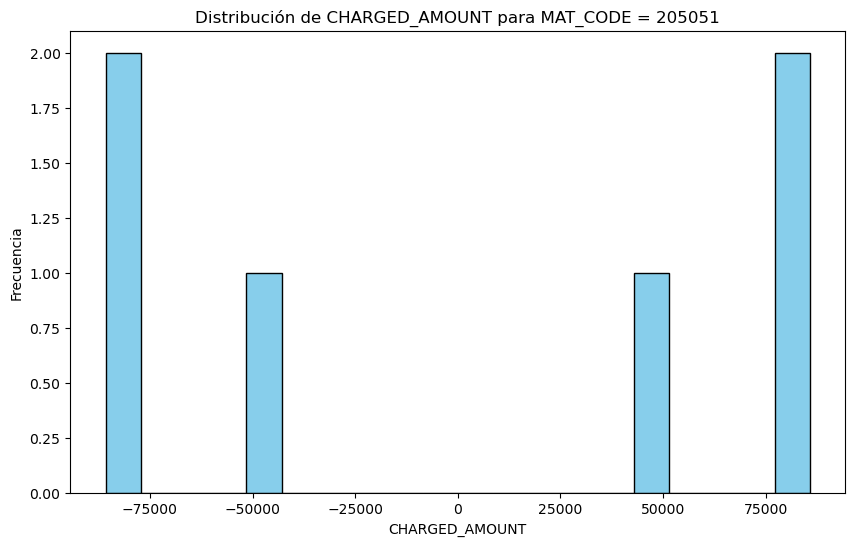

In [249]:
cesto_filtrado = cesto[cesto['MAT_CODE'] == 602019]

# Crear el histograma para la columna CHARGED_AMOUNT del DataFrame filtrado
plt.figure(figsize=(10, 6))
plt.hist(cesto_filtrado['CHARGED_AMOUNT'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de CHARGED_AMOUNT para MAT_CODE = 205051')
plt.xlabel('CHARGED_AMOUNT')
plt.ylabel('Frecuencia')
plt.show()

Podemos estimar que los valores negativos han sido un error de introducción de medida, y cambiar el signo negativo a positivo

In [251]:
# Cambiar el signo de los valores negativos y sobrescribir CHARGED_AMOUNT
cesto['CHARGED_AMOUNT'] = np.where(cesto['CHARGED_AMOUNT'] < 0, -cesto['CHARGED_AMOUNT'], cesto['CHARGED_AMOUNT'])

cesto[cesto['CHARGED_AMOUNT']<0]

,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGED_AMOUNT


Hacemos lo mismo con las columnas similares de otras tablas

In [253]:
# Eliminar filas = 0 usando drop
horno = horno.drop(horno[horno['CHARGE_AMOUNT'] == 0].index)

# Cambiar el signo de los valores negativos y sobrescribir CHARGED_AMOUNT
horno['CHARGE_AMOUNT'] = np.where(horno['CHARGE_AMOUNT'] < 0, -horno['CHARGE_AMOUNT'], horno['CHARGE_AMOUNT'])

horno[horno['CHARGE_AMOUNT']<=0]

,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGE_AMOUNT


In [254]:
# Eliminar filas = 0 usando drop
cesto2 = cesto2.drop(cesto2[cesto2['CHARGE_AMOUNT'] == 0].index)

# Cambiar el signo de los valores negativos y sobrescribir CHARGED_AMOUNT
cesto2['CHARGE_AMOUNT'] = np.where(cesto2['CHARGE_AMOUNT'] < 0, -cesto2['CHARGE_AMOUNT'], cesto2['CHARGE_AMOUNT'])

cesto2[cesto2['CHARGE_AMOUNT']<=0]

,HEATID,MAT_CODE,MAT_DEC,CHARGE_AMOUNT,DATETIME


In [255]:
# Eliminar filas = 0 usando drop
cuchara = cuchara.drop(cuchara[cuchara['MAT_CHARGED'] == 0].index)

# Cambiar el signo de los valores negativos y sobrescribir CHARGED_AMOUNT
cuchara['MAT_CHARGED'] = np.where(cuchara['MAT_CHARGED'] < 0, -cuchara['MAT_CHARGED'], cuchara['MAT_CHARGED'])

cuchara[cuchara['MAT_CHARGED']<=0]

,FILTER_KEY_DATE,HEATID,MAT_CODE,DESCR,MAT_CHARGED


El consumo de potencia del transformador tampoco debería tener valores negativos

In [257]:
trafo.describe()

,TAP,STARTTIME,DURATION,MW
count,271712.000000,271712,271712,271712.000000
mean,14.129391,2016-07-07 22:41:08.411553536,0 days 00:02:38.775872983,3.710191
min,1.000000,2015-01-01 00:56:00,-1 days +23:59:05,-1049.624000
25%,12.000000,2015-09-26 21:35:00,0 days 00:00:10,0.250000
50%,15.000000,2016-06-03 15:03:00,0 days 00:00:19,0.375000
75%,16.000000,2017-01-25 08:41:45,0 days 00:02:30,3.500000
max,18.000000,2018-07-29 08:51:00,0 days 00:47:50,999.999000
std,2.041992,NaN,0 days 00:04:31.568207066,7.042297


In [258]:
trafo[trafo['MW']<0]

,TAP,HEATID,STARTTIME,DURATION,MW
31770,17,6F2683,2016-04-22 23:06:00,0 days 00:01:10,-1049.624
64756,13,6F5223,2016-08-05 18:05:00,0 days 00:00:00,-0.375
73048,13,6F5995,2016-09-08 07:05:00,0 days 00:00:00,-0.500
76661,11,6F6257,2016-09-26 20:05:00,0 days 00:00:00,-0.250
81850,12,6F6683,2016-10-14 14:05:00,0 days 00:00:00,-0.125
81949,11,6F6689,2016-10-14 20:05:00,0 days 00:00:00,-0.375
85993,14,6F6996,2016-10-27 11:05:00,0 days 00:00:00,-0.250
86109,12,6F7005,2016-10-27 20:35:00,0 days 00:00:00,-0.375
87368,15,6F7093,2016-11-01 04:05:00,0 days 00:00:00,-0.875
87646,11,6F7112,2016-11-01 22:35:00,0 days 00:00:00,-0.250


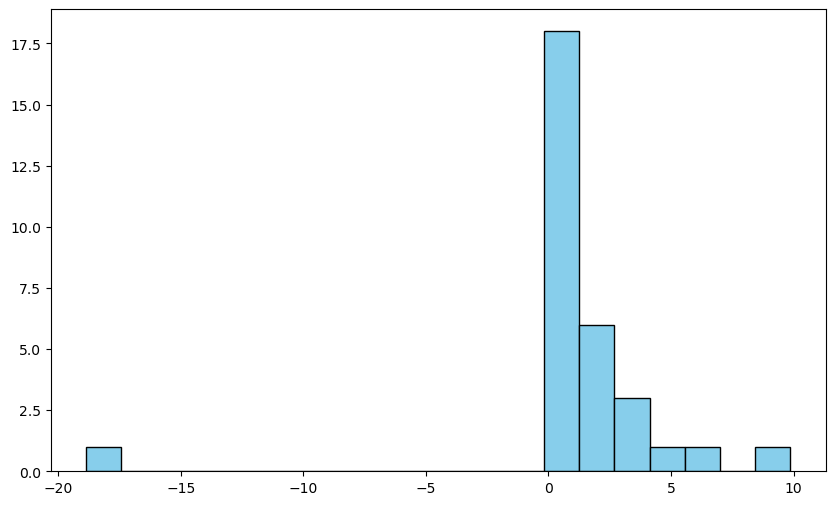

In [259]:
trafo_filtrado = trafo[trafo['HEATID'] == '5F6313']

# Crear el histograma para la columna CHARGED_AMOUNT del DataFrame filtrado
plt.figure(figsize=(10, 6))
plt.hist(trafo_filtrado['MW'], bins=20, color='skyblue', edgecolor='black')
plt.show()

Eliminamos filas con valores negativos

In [261]:
trafo = trafo.drop(trafo[trafo['MW'] < 0].index)
trafo[trafo['MW']<0]

,TAP,HEATID,STARTTIME,DURATION,MW


In [262]:
trafo.sort_values('DURATION')

,TAP,HEATID,STARTTIME,DURATION,MW
104823,15,6F8456,2016-12-29 13:35:00,-1 days +23:59:05,0.875
104258,11,6F8413,2016-12-27 13:05:00,-1 days +23:59:34,0.750
199913,13,5F2357,2015-04-06 10:55:00,0 days 00:00:00,0.000
83899,11,6F6837,2016-10-21 00:35:00,0 days 00:00:00,0.000
106381,15,7F0068,2017-01-04 06:04:00,0 days 00:00:00,0.000
...,...,...,...,...,...
201589,16,5F2511,2015-04-12 01:55:00,0 days 00:29:10,37.750
83441,11,6F6800,2016-10-19 13:09:00,0 days 00:29:19,35.250
21231,17,6F1781,2016-03-15 14:03:00,0 days 00:36:42,43.875
107887,15,7F0188,2017-01-08 20:33:00,0 days 00:41:01,48.000


Eliminamos tambien duraciones negativas

In [264]:
trafo = trafo.drop(index=[104823, 104258]).reset_index(drop=True)

In [265]:
trafo.sort_values('DURATION')

,TAP,HEATID,STARTTIME,DURATION,MW
98883,15,6F7935,2016-12-06 08:35:00,0 days 00:00:00,0.000
169229,17,8F3146,2018-05-02 21:48:00,0 days 00:00:00,0.500
122748,17,7F5177,2017-07-31 20:56:00,0 days 00:00:00,0.000
220399,17,5F4285,2015-06-25 14:16:00,0 days 00:00:00,0.250
102563,12,6F8286,2016-12-22 04:34:00,0 days 00:00:00,0.000
...,...,...,...,...,...
201567,16,5F2511,2015-04-12 01:55:00,0 days 00:29:10,37.750
83435,11,6F6800,2016-10-19 13:09:00,0 days 00:29:19,35.250
21231,17,6F1781,2016-03-15 14:03:00,0 days 00:36:42,43.875
107874,15,7F0188,2017-01-08 20:33:00,0 days 00:41:01,48.000


Pasamos a buscar negativos inesperados en el resto de tablas

In [267]:
oxigeno.describe()

,REVTIME,O2_AMOUNT,GAS_AMOUNT,O2_FLOW,GAS_FLOW
count,5748193,5.748193e+06,5.748193e+06,5.748193e+06,5.748193e+06
mean,2016-07-15 18:55:08.356982016,1.958394e+03,4.602522e+02,2.090869e+03,7.814660e+02
min,2015-01-01 00:50:37.617000,0.000000e+00,0.000000e+00,-7.000000e+00,0.000000e+00
25%,2015-09-23 05:52:38.764999936,7.510000e+02,2.760000e+02,2.360000e+02,8.300000e+01
50%,2016-06-03 12:54:34.684999936,1.771000e+03,4.700000e+02,1.509000e+03,2.590000e+02
75%,2017-02-11 23:49:06.584000,3.067000e+03,6.460000e+02,4.414000e+03,1.273000e+03
max,2018-07-29 09:20:27.743000,1.891300e+04,4.850000e+03,1.273300e+04,3.192000e+03
std,NaN,1.374063e+03,2.613516e+02,2.054957e+03,8.808715e+02


El flujo de oxígeno no puede ser negativo

In [269]:
oxigeno[oxigeno['O2_FLOW']<0].sort_values('O2_FLOW')

,REVTIME,O2_AMOUNT,GAS_AMOUNT,O2_FLOW,GAS_FLOW,HEATID
2382569,2017-02-11 00:30:13.764,0.0,0.0,-7.0,186.0,7F1021
3948780,2015-01-23 11:59:40.793,0.0,0.0,-7.0,22.0,5F0542
3837801,2015-01-03 07:09:27.452,0.0,0.0,-7.0,90.0,5F0055
3834247,2015-01-02 09:22:47.311,0.0,0.0,-7.0,91.0,5F0038
1002037,2016-06-11 10:08:43.792,0.0,0.0,-7.0,261.0,6F3884
...,...,...,...,...,...,...
2896264,2017-10-12 12:01:13.568,763.0,294.0,-1.0,108.0,7F6875
2896285,2017-10-12 12:04:53.838,1254.0,334.0,-1.0,108.0,7F6875
2896298,2017-10-12 12:07:03.996,1544.0,357.0,-1.0,109.0,7F6875
2895331,2017-10-12 09:07:44.631,2565.0,620.0,-1.0,0.0,7F6871


In [270]:
119048/5748194*100

2.07105048994519

Hay un 2% de filas con el flow negativo

<Axes: xlabel='O2_FLOW', ylabel='Count'>

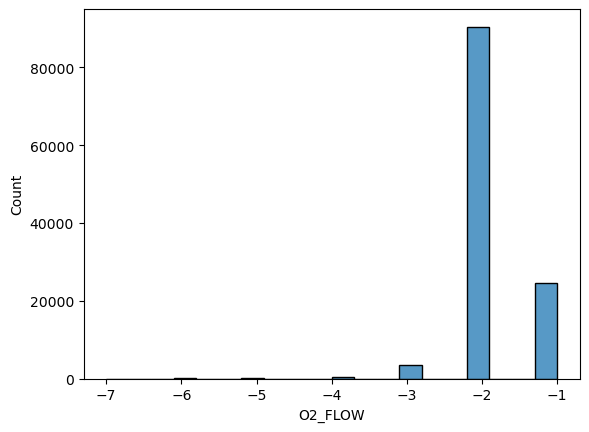

In [272]:
sns.histplot(oxigeno.loc[oxigeno['O2_FLOW']<0,'O2_FLOW'], bins=20, kde=False)

Los pocos valores negativos son valores muy bajos, así que podemos estimarlos como 0

In [274]:
# Cambiar el signo de los valores negativos y sobrescribir CHARGED_AMOUNT
oxigeno['O2_FLOW'] = np.where(oxigeno['O2_FLOW'] < 0, 0, oxigeno['O2_FLOW'])

oxigeno[oxigeno['O2_FLOW']<0]

C:\Users\lucia\AppData\Local\Temp\ipykernel_15104\4286367120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxigeno['O2_FLOW'] = np.where(oxigeno['O2_FLOW'] < 0, 0, oxigeno['O2_FLOW'])


,REVTIME,O2_AMOUNT,GAS_AMOUNT,O2_FLOW,GAS_FLOW,HEATID


### Datos fuera de límite

Vamos a hacer una búsqueda de valores anómalos en cada tabla.

Lo haré con el `Z score`, considerando que los datos siguen una distribución normal, y que los valores que se salen mucho de la distribución normal, tienen alguna anomalía y hay que modificarlos. Pondré como límite un valor de Z score de 20 o -20

In [277]:
import scipy.stats as stats

float_columns = final.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(final[col].dropna())
    outliers = final[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'VALC': 1, 'VALSI': 2, 'VALMN': 0, 'VALP': 1, 'VALS': 0, 'VALCU': 0, 'VALCR': 0, 'VALMO': 0, 'VALNI': 0, 'VALAS': 0, 'VALSN': 0, 'VALN': 2}


<Axes: xlabel='VALSI', ylabel='Count'>

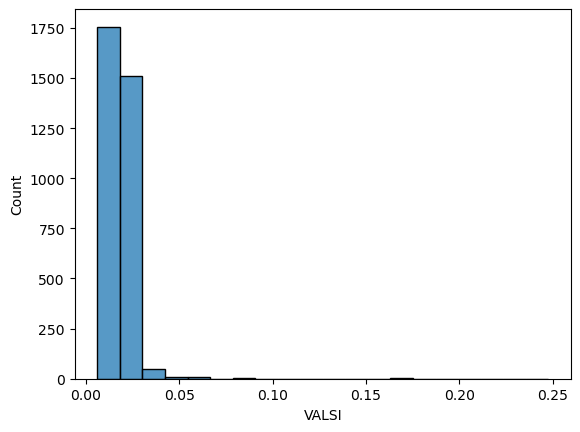

In [278]:
sns.histplot(final['VALSI'], bins=20, kde=False)

Para todos esos valores que son extremadamente anómalos, los estimamos con la mediana

In [280]:
# Rellenar valores anómalos en cada columna con la mediana correspondiente
for col in float_columns:
    median_value = final[col].median() 
    anom_index = anomalos_zscore[col].dropna().index  # Índices de valores anómalos en esta columna
    final.loc[anom_index, col] = median_value  # Reemplazar con la mediana

In [281]:
float_columns = final.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(final[col].dropna())
    outliers = final[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'VALC': 0, 'VALSI': 3, 'VALMN': 0, 'VALP': 0, 'VALS': 0, 'VALCU': 0, 'VALCR': 0, 'VALMO': 0, 'VALNI': 0, 'VALAS': 0, 'VALSN': 0, 'VALN': 1}


Comprobamos en el resto de tablas

In [283]:
float_columns = inicial.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(inicial[col].dropna())
    outliers = inicial[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'VALC': 0, 'VALSI': 0, 'VALMN': 0, 'VALP': 0, 'VALS': 0, 'VALCU': 0, 'VALCR': 0, 'VALMO': 2, 'VALNI': 0}


<Axes: xlabel='VALMO', ylabel='Count'>

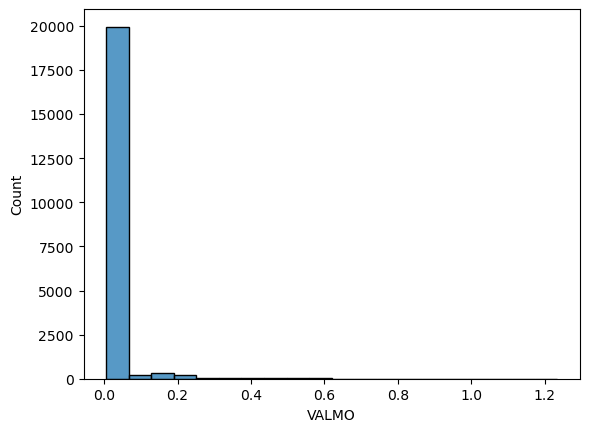

In [284]:
sns.histplot(inicial['VALMO'], bins=20, kde=False)

In [285]:
for col in float_columns:
    median_value = inicial[col].median()  
    anom_index = anomalos_zscore[col].dropna().index  
    inicial.loc[anom_index, col] = median_value  

In [286]:
float_columns = ferro.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(ferro[col].dropna())
    outliers = ferro[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'Nb': 0, 'Ta': 0, 'Mo': 0, 'V': 0, 'Ca': 0, 'Al': 0, 'Mg': 0, 'P': 0, 'S': 0, 'Ash': 0, 'Moisture': 0, 'C': 0, 'Si': 0, 'Mn': 0, 'Cr': 0, 'Ti': 0, 'Cu': 0, 'Zn': 0, 'Ni': 0, 'Pb': 0, 'Sn': 0, 'Al2O3': 0, 'CaO+MgO': 0, 'CaO': 0, 'SiO2': 0, 'MgO': 0, 'FeO': 0, 'Fe2O3': 0, 'Cr2O3': 0, 'TiO2': 0, 'Na+K': 0, 'TiO': 0, 'As': 0, 'SiC': 0, 'Zr': 0}


In [287]:
float_columns = trafo.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(trafo[col].dropna())
    outliers = trafo[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'MW': 1}


In [288]:
trafo[trafo['MW']>100]

,TAP,HEATID,STARTTIME,DURATION,MW
31786,11,6F2684,2016-04-23 13:36:00,0 days 00:02:50,999.999


Hay un dato anómalo en el consumo del transformador. Estimamos con la mediana

In [290]:
trafo.loc[trafo['MW']>100, 'MW'] = trafo['MW'].median()

In [291]:
float_columns = temp.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(temp[col].dropna())
    outliers = temp[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'TEMP': 0, 'VALO2_PPM': 0}


In [292]:
float_columns = oxigeno.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(oxigeno[col].dropna())
    outliers = oxigeno[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'O2_AMOUNT': 0, 'GAS_AMOUNT': 0, 'O2_FLOW': 0, 'GAS_FLOW': 0}


In [293]:
float_columns = carbono.select_dtypes(include=['float']).columns
anomalos_zscore = pd.DataFrame()
outlier_counts_zscore = {}

for col in float_columns:
    z_scores = stats.zscore(carbono[col].dropna())
    outliers = carbono[col][(z_scores > 20) | (z_scores < -20)]
    anomalos_zscore = pd.concat([anomalos_zscore, outliers], axis=1)
    outlier_counts_zscore[col] = len(outliers)  # Contar anómalos para la columna

print("Número de valores anómalos por columna (Z-score):")
print(outlier_counts_zscore)

Número de valores anómalos por columna (Z-score):
{'INJ_AMOUNT_CARBON': 1293, 'INJ_FLOW_CARBON': 6}


<Axes: xlabel='INJ_AMOUNT_CARBON', ylabel='Count'>

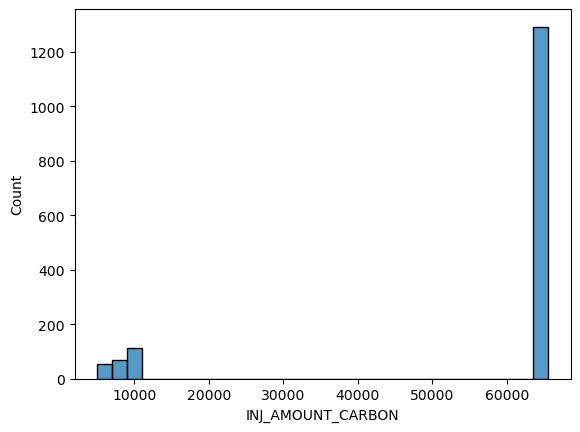

In [294]:
sns.histplot(carbono.loc[carbono['INJ_AMOUNT_CARBON']>5000,'INJ_AMOUNT_CARBON'], bins=30, kde=False)

In [295]:
carbono.sort_values(by='INJ_AMOUNT_CARBON', ascending = False).head(15)

,REVTIME,INJ_AMOUNT_CARBON,INJ_FLOW_CARBON,HEATID
3230761,2015-06-11 00:16:05.135,65535.0,0.0,5F3947
1045375,2016-09-07 22:02:50.044,65535.0,0.0,6F5985
1045373,2016-09-07 22:02:30.035,65535.0,0.0,6F5985
1045372,2016-09-07 22:02:19.991,65535.0,0.0,6F5985
1045371,2016-09-07 22:02:10.026,65535.0,0.0,6F5985
1045370,2016-09-07 22:01:59.966,65535.0,0.0,6F5985
1045369,2016-09-07 22:01:49.954,65535.0,0.0,6F5985
1578635,2017-01-28 14:37:44.982,65535.0,25.0,7F0694
1045368,2016-09-07 22:01:41.948,65535.0,0.0,6F5985
1045367,2016-09-07 22:01:31.939,65535.0,0.0,6F5985


Vamos a dejar de momento esos valores de la tabla carbono porque no sabemos si los vamos a necesitar y no sabemos tampoco interpretarlos

# 2. EDA

## Orden introducción materiales

Debido a la complejidad de interpretación de los datos, vamos a hacer un gráfico temporal donde se vea el orden de cada tabla.

Esto nos ayudará también a entender el proceso y cuándo se realizan las mediciones.

Vamos a graficar la cantidad de materiales añadidos en cada momento, contando con los datos de 4 tablas distintas: `cesto`, `horno`, `cesto2` y `cuchara`. Así podremos ver el orden de estas tablas entre sí.

También vamos a representar la hora en la que se realizan las mediciones de las tablas `inicial` y `final`, para comprender en qué etapa del proceso se mide

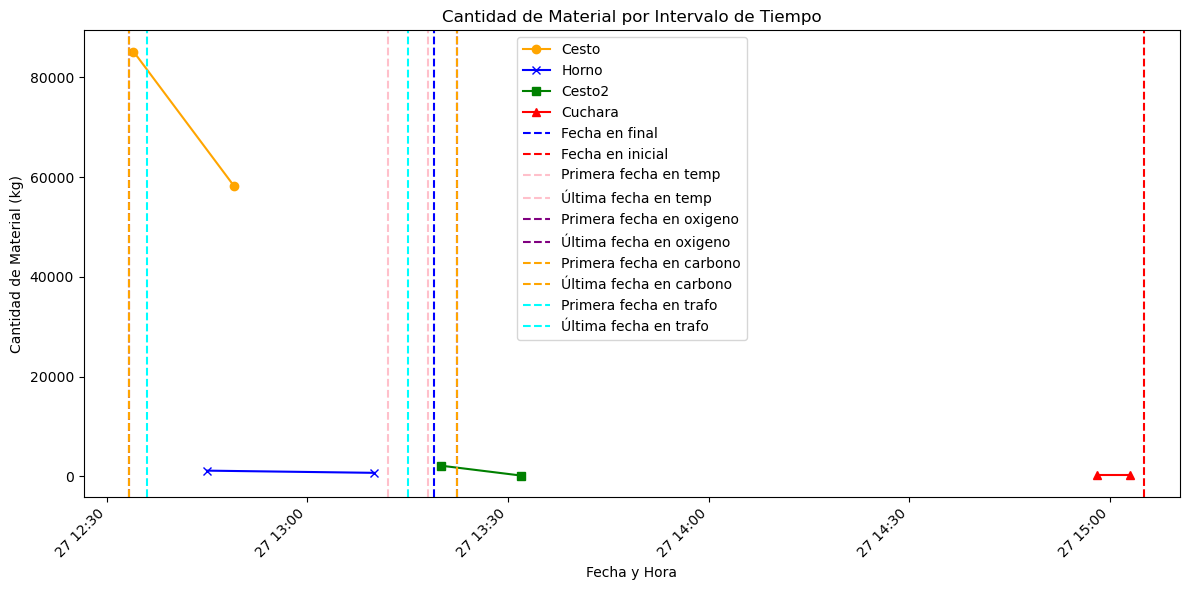

In [321]:
# Obtener un valor aleatorio de HEATID
heatid = random.choice(final['HEATID'].unique())

# Agrupar por 'DATETIME' y sumar los valores de cada grupo
agrupado1 = cesto.loc[cesto['HEATID'] == heatid].groupby('DATETIME')['CHARGED_AMOUNT'].sum()
agrupado2 = horno.loc[horno['HEATID'] == heatid].groupby('DATETIME')['CHARGE_AMOUNT'].sum()
agrupado3 = cesto2.loc[cesto2['HEATID'] == heatid].groupby('DATETIME')['CHARGE_AMOUNT'].sum()
agrupado4 = cuchara.loc[cuchara['HEATID'] == heatid].groupby('FILTER_KEY_DATE')['MAT_CHARGED'].sum()

# Obtener las fechas de 'final' e 'inicial' para ese HEATID, si existen
datetime_final = final.loc[final['HEATID'] == heatid, 'DATETIME']
datetime_inicial = inicial.loc[inicial['HEATID'] == heatid, 'DATETIME']
datetime_final_valid = datetime_final.iloc[0] if not datetime_final.empty else None
datetime_inicial_valid = datetime_inicial.iloc[0] if not datetime_inicial.empty else None

# Obtener la primera y última fecha de la tabla temp para el mismo HEATID
temp_dates = temp.loc[temp['HEATID'] == heatid, 'DATETIME']
first_temp_date = temp_dates.min() if not temp_dates.empty else None
last_temp_date = temp_dates.max() if not temp_dates.empty else None

# Obtener la primera y última fecha de REVTIME en la tabla oxigeno para el mismo HEATID
oxigeno_dates = oxigeno.loc[oxigeno['HEATID'] == heatid, 'REVTIME']
first_oxigeno_date = oxigeno_dates.min() if not oxigeno_dates.empty else None
last_oxigeno_date = oxigeno_dates.max() if not oxigeno_dates.empty else None

# Obtener la primera y última fecha de REVTIME en la tabla carbono para el mismo HEATID
carbono_dates = carbono.loc[carbono['HEATID'] == heatid, 'REVTIME']
first_carbono_date = carbono_dates.min() if not carbono_dates.empty else None
last_carbono_date = carbono_dates.max() if not carbono_dates.empty else None

# Obtener la primera y última fecha de STARTTIME en la tabla trafo para el mismo HEATID
trafo_dates = trafo.loc[trafo['HEATID'] == heatid, 'STARTTIME']
first_trafo_date = trafo_dates.min() if not trafo_dates.empty else None
last_trafo_date = trafo_dates.max() if not trafo_dates.empty else None

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Graficar cada conjunto de datos con un color diferente
plt.plot(agrupado1.index, agrupado1.values, label='Cesto', color='orange', marker='o')
plt.plot(agrupado2.index, agrupado2.values, label='Horno', color='blue', marker='x')
plt.plot(agrupado3.index, agrupado3.values, label='Cesto2', color='green', marker='s')
plt.plot(agrupado4.index, agrupado4.values, label='Cuchara', color='red', marker='^')

# Añadir las líneas verticales si las fechas son válidas
if datetime_final_valid is not None:
    plt.axvline(x=datetime_final_valid, color='blue', linestyle='--', label='Fecha en final')

if datetime_inicial_valid is not None:
    plt.axvline(x=datetime_inicial_valid, color='red', linestyle='--', label='Fecha en inicial')

# Añadir las líneas verticales para la primera y última fecha de temp si existen
if first_temp_date is not None:
    plt.axvline(x=first_temp_date, color='pink', linestyle='--', label='Primera fecha en temp')

if last_temp_date is not None:
    plt.axvline(x=last_temp_date, color='pink', linestyle='--', label='Última fecha en temp')

# Añadir las líneas verticales para la primera y última fecha de REVTIME en oxigeno
if first_oxigeno_date is not None:
    plt.axvline(x=first_oxigeno_date, color='purple', linestyle='--', label='Primera fecha en oxigeno')

if last_oxigeno_date is not None:
    plt.axvline(x=last_oxigeno_date, color='purple', linestyle='--', label='Última fecha en oxigeno')

# Añadir las líneas verticales para la primera y última fecha de REVTIME en carbono
if first_carbono_date is not None:
    plt.axvline(x=first_carbono_date, color='orange', linestyle='--', label='Primera fecha en carbono')

if last_carbono_date is not None:
    plt.axvline(x=last_carbono_date, color='orange', linestyle='--', label='Última fecha en carbono')

# Añadir las líneas verticales para la primera y última fecha de STARTTIME en trafo
if first_trafo_date is not None:
    plt.axvline(x=first_trafo_date, color='aqua', linestyle='--', label='Primera fecha en trafo')

if last_trafo_date is not None:
    plt.axvline(x=last_trafo_date, color='aqua', linestyle='--', label='Última fecha en trafo')

# Añadir etiquetas y título
plt.xlabel('Fecha y Hora')  # Etiqueta eje X
plt.ylabel('Cantidad de Material (kg)')  # Etiqueta eje Y
plt.title('Cantidad de Material por Intervalo de Tiempo')  # Título del gráfico

# Ajustar el formato del eje X para mostrar correctamente las fechas
plt.xticks(rotation=45, ha='right')

# Añadir una leyenda para diferenciar las series
plt.legend()

# Mostrar el gráfico
plt.tight_layout()  # Ajusta el gráfico para que no se corten las etiquetas
plt.show()

Concluimos tras este grafico que las materias primas son las que están en la tabla `cesto`

Tambien podemos ver que la medición que hemos llamado final, siempre ocurre antes que la inicial, así que están al revés. Y, la mayoría de las veces, entre ambas mediciones se añaden componentes de la tabla cuchara, probablemente para mejorar las condiciones del acero final.

Así que más adelante, podríamos intentar buscar una correlación entre el resultado de la medición inicial, los ingredientes de la cuchara, y el resultado final

## Materiales más usados

In [326]:
cesto.nunique()

MAT_CODE             50
MAT_DEC              46
HEATID            20806
DATETIME          42866
CHARGED_AMOUNT    29622
dtype: int64

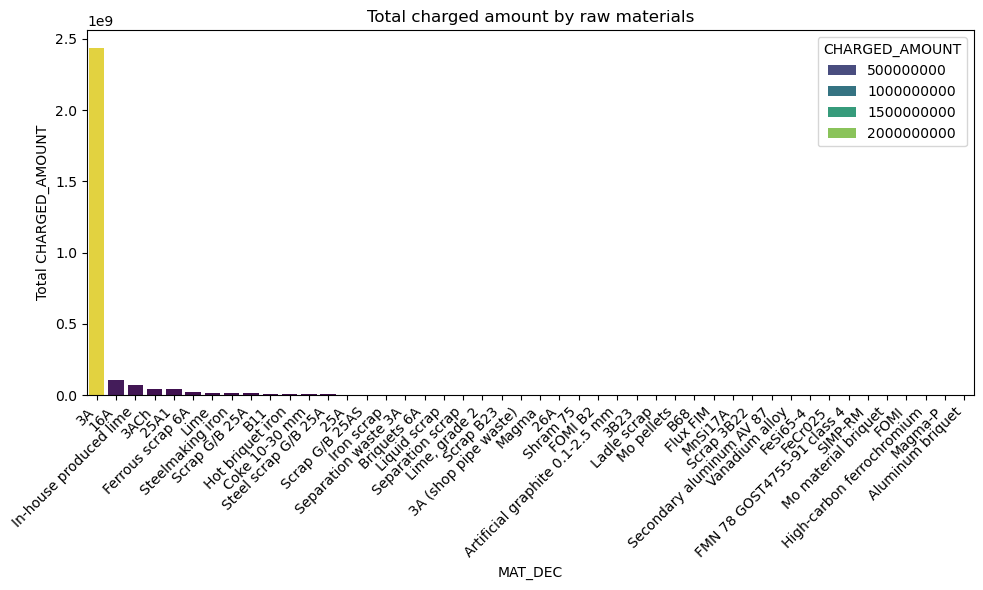

In [327]:
# Agrupa y ordena de mayor a menor
total_amounts = cesto.groupby('MAT_DEC')['CHARGED_AMOUNT'].sum().reset_index().sort_values(by='CHARGED_AMOUNT', ascending=False)

# Gráfico de barras ordenado
plt.figure(figsize=(10, 6))
sns.barplot(
    data=total_amounts,
    x='MAT_DEC',
    y='CHARGED_AMOUNT',
    hue='CHARGED_AMOUNT',
    palette='viridis',
    order=total_amounts['MAT_DEC']  # Especifica el orden
)
plt.title('Total charged amount by raw materials')
plt.xlabel('MAT_DEC')
plt.ylabel('Total CHARGED_AMOUNT')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

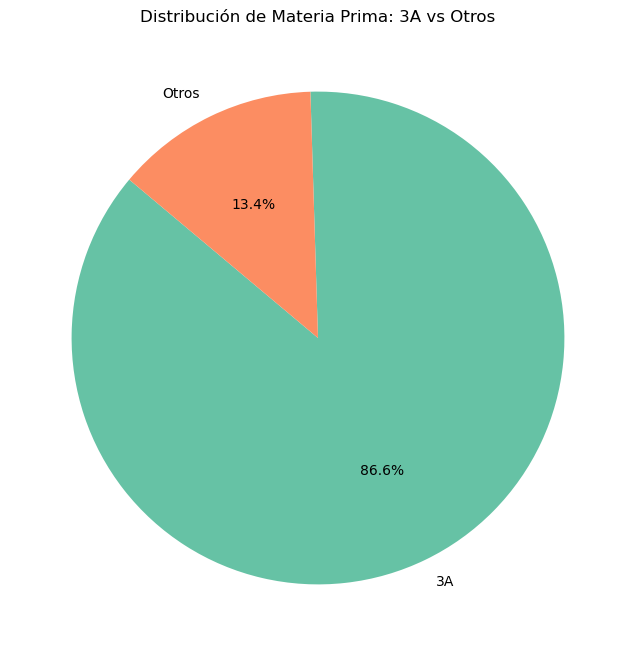

In [328]:
# Filtrar los datos donde MAT_DEC sea '3A' y agrupar todos los demás materiales bajo la categoría 'Otros'
material_3A = cesto[cesto['MAT_DEC'] == '3A']
otros_materiales = cesto[cesto['MAT_DEC'] != '3A'].groupby('MAT_DEC')['CHARGED_AMOUNT'].sum().sum()

# Crear un nuevo DataFrame para los materiales 3A
materiales_pastel = material_3A.groupby('MAT_DEC')['CHARGED_AMOUNT'].sum().reset_index()

# Valores que quieres añadir en la nueva fila
nueva_fila = {'MAT_DEC': 'Otros', 'CHARGED_AMOUNT': otros_materiales}  # Por ejemplo

# Convertir la nueva fila a DataFrame
nueva_fila_df = pd.DataFrame([nueva_fila])

# Insertar la nueva fila en la posición 1
materiales_pastel = pd.concat([materiales_pastel.iloc[:1], nueva_fila_df, materiales_pastel.iloc[1:]]).reset_index(drop=True)

# Crear el gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(
    materiales_pastel['CHARGED_AMOUNT'], 
    labels=materiales_pastel['MAT_DEC'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('Set2', len(materiales_pastel))
)

# Añadir título
plt.title('Distribución de Materia Prima: 3A vs Otros')

# Mostrar el gráfico
plt.show()

Teniendo en cuenta que el primer material más usado está muy lejos de los demás, vamos a ver la distribución sin el primer material

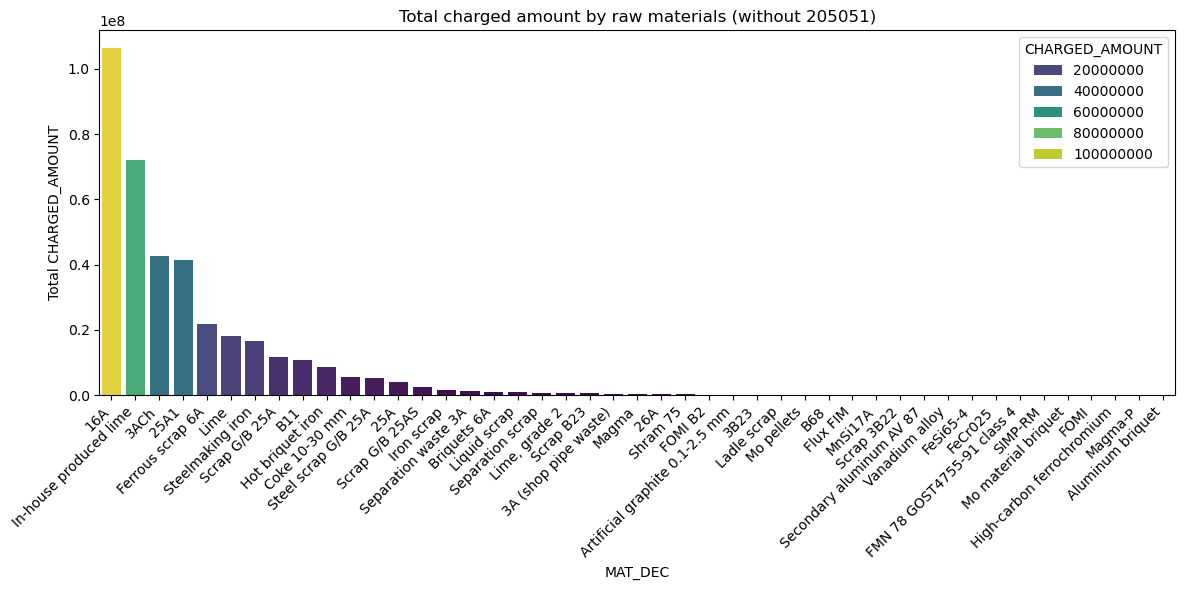

In [330]:
# Agrupa, elimina el MAT_CODE 205051, y ordena de mayor a menor
total_amounts = (
    cesto[cesto['MAT_CODE'] != 205051]
    .groupby('MAT_DEC')['CHARGED_AMOUNT']
    .sum()
    .reset_index()
    .sort_values(by='CHARGED_AMOUNT', ascending=False)
)

# Gráfico de barras ordenado
plt.figure(figsize=(12, 6))  # Aumentar el ancho de la figura
sns.barplot(
    data=total_amounts,
    x='MAT_DEC',
    y='CHARGED_AMOUNT',
    hue='CHARGED_AMOUNT',
    palette='viridis',
    order=total_amounts['MAT_DEC']  # Especifica el orden
)
plt.title('Total charged amount by raw materials (without 205051)')
plt.xlabel('MAT_DEC')
plt.ylabel('Total CHARGED_AMOUNT')

# Alinear etiquetas a la derecha y rotar
plt.xticks(rotation=45, ha='right')  # Cambiar el ángulo a 45 grados y alinear a la derecha
plt.tight_layout()
plt.show()

In [331]:
total_amounts = cesto.groupby(['MAT_CODE','MAT_DEC'])['CHARGED_AMOUNT'].sum().reset_index().sort_values('CHARGED_AMOUNT', ascending=False)
total_amounts.head(5)

,MAT_CODE,MAT_DEC,CHARGED_AMOUNT
20,205051,3A,2.437950e+09
23,205180,16A,1.064815e+08
30,360258,In-house produced lime,7.208891e+07
35,601025,25A1,4.141439e+07
28,205237,3ACh,3.437846e+07


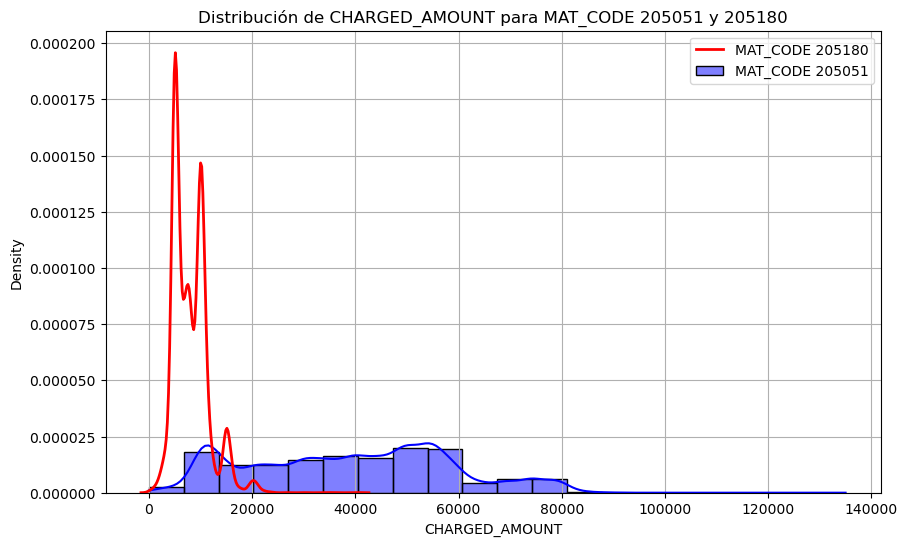

In [332]:
# Filtra los datos para MAT_CODE 205051 y 205180
filtered_data_205051 = cesto[cesto['MAT_CODE'] == 205051]
filtered_data_205180 = cesto[cesto['MAT_CODE'] == 205180]

# Crea el histograma y la curva de densidad para 205051
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data_205051['CHARGED_AMOUNT'], bins=20, kde=True, stat='density', color='blue', label='MAT_CODE 205051')

# Agrega la curva de densidad para 205180 sobre el mismo gráfico
sns.kdeplot(filtered_data_205180['CHARGED_AMOUNT'], color='red', label='MAT_CODE 205180', linewidth=2)

# Configuración del gráfico
plt.title('Distribución de CHARGED_AMOUNT para MAT_CODE 205051 y 205180')
plt.xlabel('CHARGED_AMOUNT')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

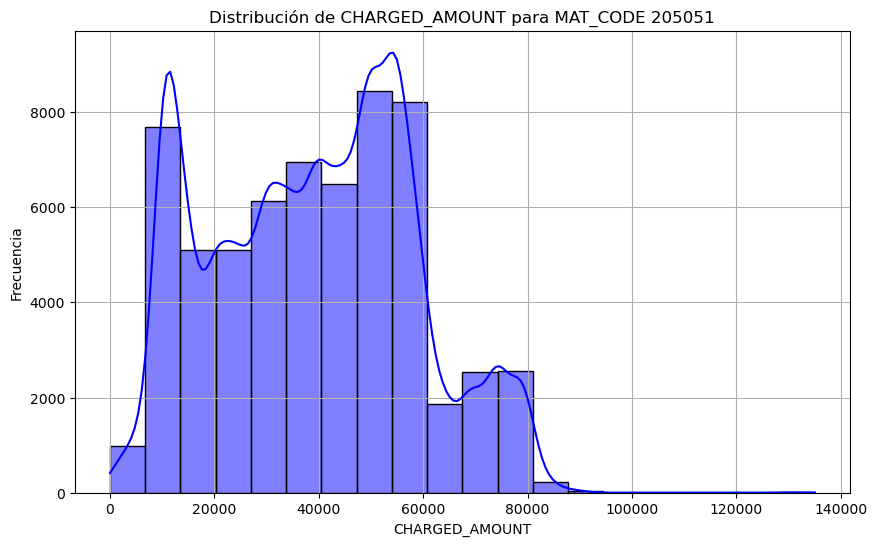

In [333]:
filtered_data = cesto[cesto['MAT_CODE'] == 205051]

# Crea un histograma para visualizar la distribución de CHARGED_AMOUNT
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['CHARGED_AMOUNT'], bins=20, kde=True, color='blue')

# Configuración del gráfico
plt.title('Distribución de CHARGED_AMOUNT para MAT_CODE 205051')
plt.xlabel('CHARGED_AMOUNT')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Para los materiales introducidos desde el cesto, hay una clara diferencia en las cantidades en las que se introducen. El material 3A, que es una chatarra ferrosa, es el más utilizado.

Además, hemos comprobado con la distribución en histograma que la mayor cantidad del material 3A no corresponde a un único valor anómalo, sino que en general las adiciones de ese material son muy superiores.

In [335]:
horno.nunique()

MAT_CODE            48
MAT_DEC             47
HEATID           20506
DATETIME         37367
CHARGE_AMOUNT     2394
dtype: int64

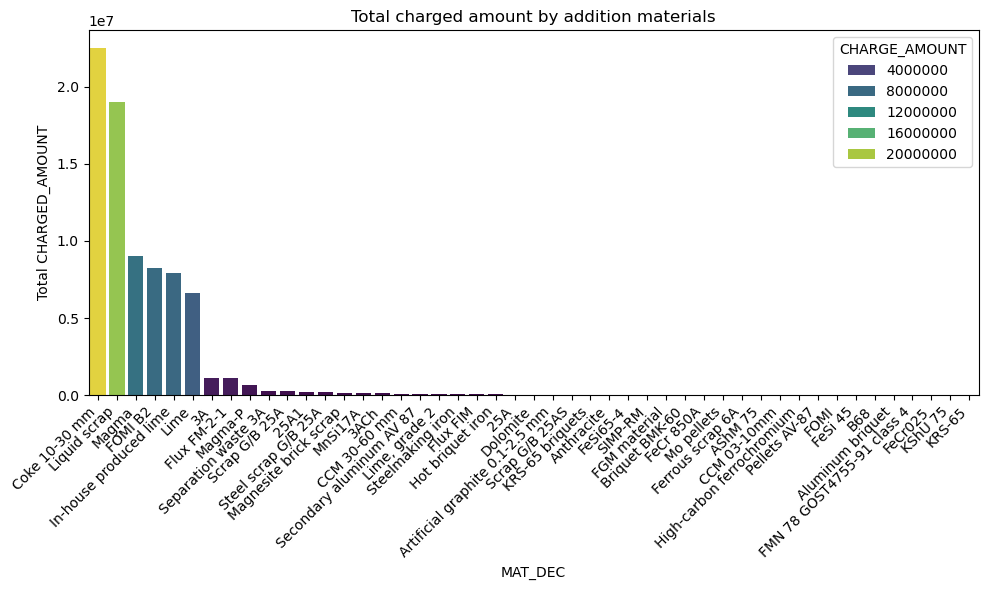

In [336]:
# Agrupa y ordena de mayor a menor
total_amounts = horno.groupby('MAT_DEC')['CHARGE_AMOUNT'].sum().reset_index().sort_values(by='CHARGE_AMOUNT', ascending=False)

# Gráfico de barras ordenado
plt.figure(figsize=(10, 6))
sns.barplot(
    data=total_amounts,
    x='MAT_DEC',
    y='CHARGE_AMOUNT',
    hue='CHARGE_AMOUNT',
    palette='viridis',
    order=total_amounts['MAT_DEC']  # Especifica el orden
)
plt.title('Total charged amount by addition materials')
plt.xlabel('MAT_DEC')
plt.ylabel('Total CHARGED_AMOUNT')
plt.xticks(rotation=45, ha='right' )
plt.tight_layout()
plt.show()

In [337]:
cesto2.nunique()

HEATID           20801
MAT_CODE            75
MAT_DEC             72
CHARGE_AMOUNT     3207
DATETIME         41481
dtype: int64

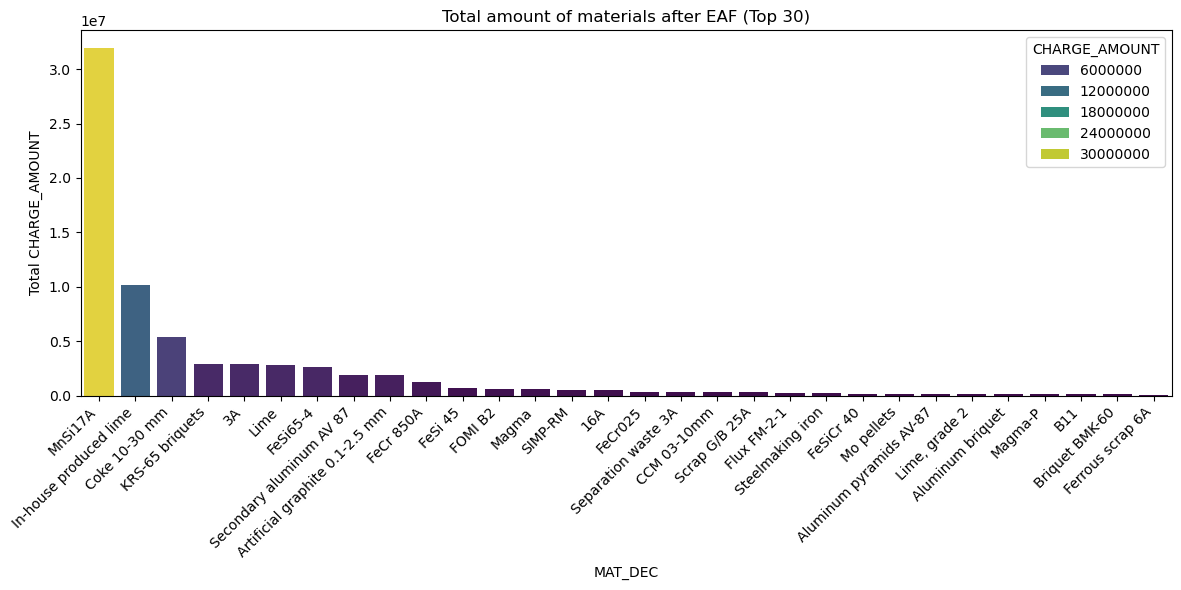

In [338]:
# Agrupa y ordena de mayor a menor
total_amounts = (
    cesto2.groupby('MAT_DEC')['CHARGE_AMOUNT']
    .sum()
    .reset_index()
    .sort_values(by='CHARGE_AMOUNT', ascending=False)
)

# Selecciona solo los 30 materiales más altos
top_30_amounts = total_amounts.head(30)

# Gráfico de barras ordenado
plt.figure(figsize=(12, 6))  # Aumentar el ancho de la figura para acomodar las etiquetas
sns.barplot(
    data=top_30_amounts,
    x='MAT_DEC',
    y='CHARGE_AMOUNT',
    hue='CHARGE_AMOUNT',
    palette='viridis',
    order=top_30_amounts['MAT_DEC']  # Especifica el orden
)
plt.title('Total amount of materials after EAF (Top 30)')
plt.xlabel('MAT_DEC')
plt.ylabel('Total CHARGE_AMOUNT')
plt.xticks(rotation=45, ha='right')  # Alinear etiquetas a la derecha
plt.tight_layout()
plt.show()

In [339]:
cuchara.nunique()

FILTER_KEY_DATE    88529
HEATID             20374
MAT_CODE              64
DESCR                 63
MAT_CHARGED          808
dtype: int64

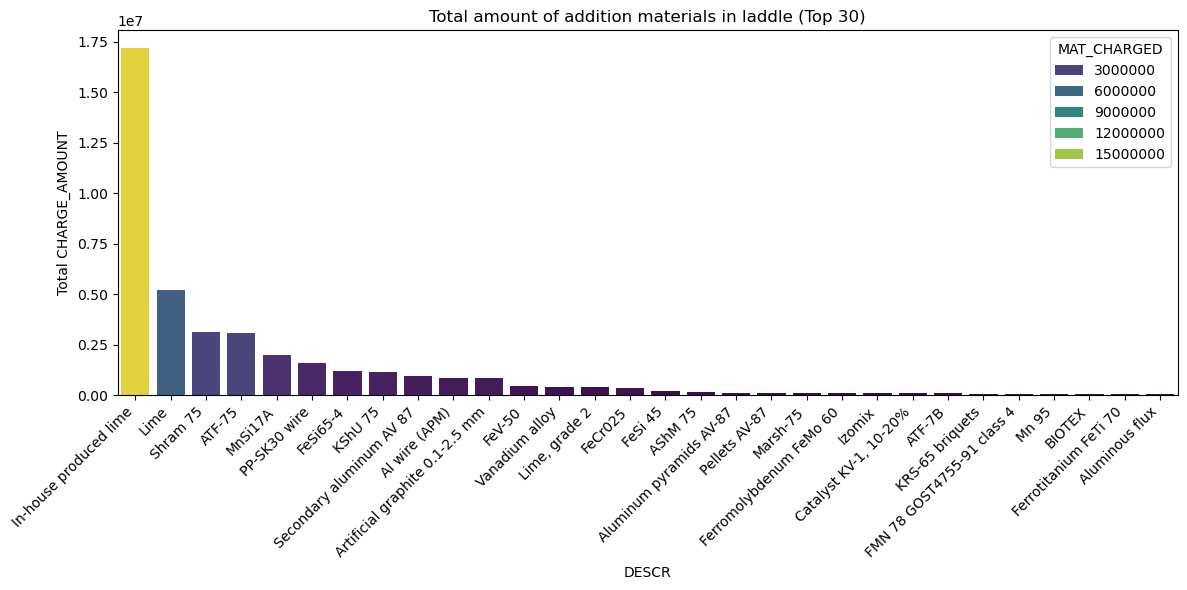

In [340]:
# Agrupa y ordena de mayor a menor
total_amounts = (
    cuchara.groupby('DESCR')['MAT_CHARGED']
    .sum()
    .reset_index()
    .sort_values(by='MAT_CHARGED', ascending=False)
)

# Selecciona solo los 30 materiales más altos
top_30_amounts = total_amounts.head(30)

# Gráfico de barras ordenado
plt.figure(figsize=(12, 6))  # Aumentar el ancho de la figura para acomodar las etiquetas
sns.barplot(
    data=top_30_amounts,
    x='DESCR',
    y='MAT_CHARGED',
    hue='MAT_CHARGED',
    palette='viridis',
    order=top_30_amounts['DESCR']  # Especifica el orden
)
plt.title('Total amount of addition materials in laddle (Top 30)')
plt.xlabel('DESCR')
plt.ylabel('Total CHARGE_AMOUNT')
plt.xticks(rotation=45, ha='right')  # Alinear etiquetas a la derecha
plt.tight_layout()
plt.show()

## Composición materiales

Esta tabla `materiasprimas` que vamos a crear es muy importante, porque reune la informacion de todos los tipos de materiales que se han usado como materias primas para todos los lotes de la base de datos.

Es una unión de las tablas `cesto`, `cesto2`, `horno` y `cuchara`.

In [343]:
materiasprimas = pd.merge(horno, cesto, on=['HEATID', 'MAT_CODE'], how='outer').merge(cesto2,on=['HEATID', 'MAT_CODE'], how='outer').merge(cuchara,on=['HEATID', 'MAT_CODE'], how='outer')[['MAT_CODE','HEATID','CHARGE_AMOUNT_x','CHARGE_AMOUNT_y','CHARGED_AMOUNT','MAT_CHARGED']]
materiasprimas['CHARGED_AMOUNT'] = materiasprimas[['CHARGE_AMOUNT_x','CHARGE_AMOUNT_y','CHARGED_AMOUNT','MAT_CHARGED']].fillna(0).sum(axis=1)
materiasprimas=materiasprimas[['MAT_CODE','HEATID','CHARGED_AMOUNT']]
materiasprimas

,MAT_CODE,HEATID,CHARGED_AMOUNT
0,201010,5F0002,17560.0
1,202007,5F0002,723.0
2,202008,5F0002,330.0
3,202034,5F0002,710.0
4,203068,5F0002,575.0
...,...,...,...
636894,205234,8F5473,73.0
636895,205237,8F5473,22042.0
636896,205237,8F5473,32699.0
636897,205240,8F5473,12892.0


In [344]:
materiasprimas.MAT_CODE.nunique()

115

In [345]:
ferro.shape

(52, 39)

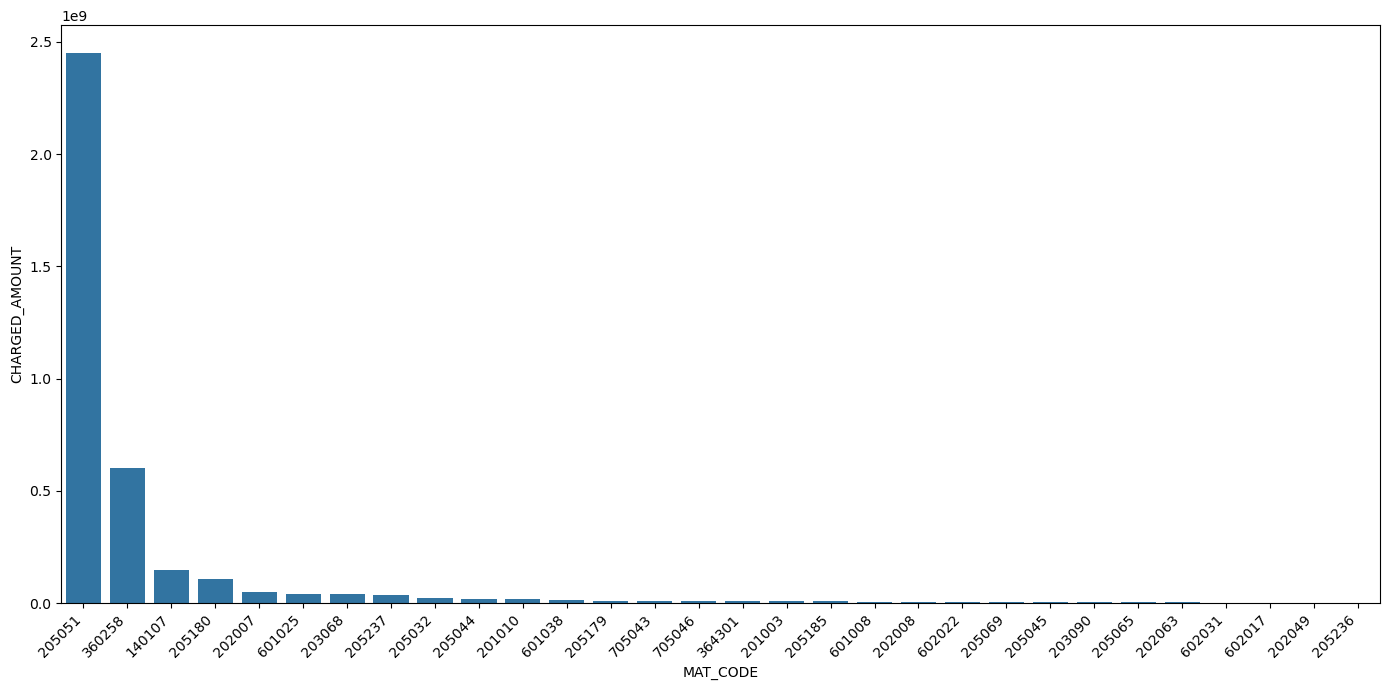

In [346]:
materiasprimas_agrupadas = materiasprimas.groupby('MAT_CODE')['CHARGED_AMOUNT'].sum().reset_index().sort_values('CHARGED_AMOUNT', ascending=False)

# Filtrar los 30 valores más altos
top_30_materiasprimas = materiasprimas_agrupadas.sort_values(by='CHARGED_AMOUNT', ascending=False).head(30)

# Gráfico de barras ordenado
plt.figure(figsize=(14, 7))  # Ajustar el tamaño de la figura para mejor visibilidad
sns.barplot(
    data=top_30_materiasprimas,
    x='MAT_CODE',
    y='CHARGED_AMOUNT',
    order=top_30_materiasprimas['MAT_CODE']  # Ordenar en el gráfico según los 30 valores más altos
)
plt.xticks(rotation=45, ha='right')  # Girar etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Acomodar el diseño para que no se sobrepongan los elementos
plt.show()

Como conclusión, no vamos a utilizar la tabla ferro para unirla a la composición de cada material porque en ella no están reflejados todos los materiales, sino solo 52 sobre el total de 103.

Voy a comprobar si los materiales que están en la tabla ferro corresponden solamente con alguna de las 4 tablas de materiales de carga, o tiene materiales sueltos

In [349]:
# Verificar si todos los MAT_CODE de cesto están en ferro
todos_en_ferro_cesto = cesto['MAT_CODE'].isin(ferro['MAT_CODE']).all()

# Verificar si todos los MAT_CODE de cesto2 están en ferro
todos_en_ferro_cesto2 = cesto2['MAT_CODE'].isin(ferro['MAT_CODE']).all()

# Verificar si todos los MAT_CODE de horno están en ferro
todos_en_ferro_horno = horno['MAT_CODE'].isin(ferro['MAT_CODE']).all()

# Verificar si todos los MAT_CODE de cuchara están en ferro
todos_en_ferro_cuchara = cuchara['MAT_CODE'].isin(ferro['MAT_CODE']).all()

# Imprimir los resultados
print(f"Todos los MAT_CODE de cesto están en ferro: {todos_en_ferro_cesto}")
print(f"Todos los MAT_CODE de cesto2 están en ferro: {todos_en_ferro_cesto2}")
print(f"Todos los MAT_CODE de horno están en ferro: {todos_en_ferro_horno}")
print(f"Todos los MAT_CODE de cuchara están en ferro: {todos_en_ferro_cuchara}")

Todos los MAT_CODE de cesto están en ferro: False
Todos los MAT_CODE de cesto2 están en ferro: False
Todos los MAT_CODE de horno están en ferro: False
Todos los MAT_CODE de cuchara están en ferro: False


## Gasto energético

In [351]:
random_heatid = np.random.choice(trafo['HEATID'].unique())

trafo[trafo['HEATID']==random_heatid].sort_values('STARTTIME')

,TAP,HEATID,STARTTIME,DURATION,MW
151022,16,7F7721,2017-11-12 08:43:00,0 days 00:00:10,0.50
151026,15,7F7721,2017-11-12 08:43:00,0 days 00:00:50,1.00
151020,17,7F7721,2017-11-12 08:44:00,0 days 00:13:41,19.50
151025,15,7F7721,2017-11-12 09:00:00,0 days 00:01:01,1.50
151021,17,7F7721,2017-11-12 09:01:00,0 days 00:05:30,7.25
151023,16,7F7721,2017-11-12 09:07:00,0 days 00:00:10,0.25
151024,15,7F7721,2017-11-12 09:07:00,0 days 00:04:50,7.25
151027,14,7F7721,2017-11-12 09:12:00,0 days 00:00:10,0.25
151028,13,7F7721,2017-11-12 09:12:00,0 days 00:07:51,11.00


In [352]:
trafo.describe()

,TAP,STARTTIME,DURATION,MW
count,271688.000000,271688,271688,271688.000000
mean,14.129454,2016-07-07 22:32:08.310267392,0 days 00:02:38.775308442,3.711461
min,1.000000,2015-01-01 00:56:00,0 days 00:00:00,0.000000
25%,12.000000,2015-09-26 21:35:00,0 days 00:00:10,0.250000
50%,15.000000,2016-06-03 14:43:30,0 days 00:00:19,0.375000
75%,16.000000,2017-01-25 14:53:00,0 days 00:02:30,3.500000
max,18.000000,2018-07-29 08:51:00,0 days 00:47:50,54.000000
std,2.041974,NaN,0 days 00:04:31.535010352,6.466978


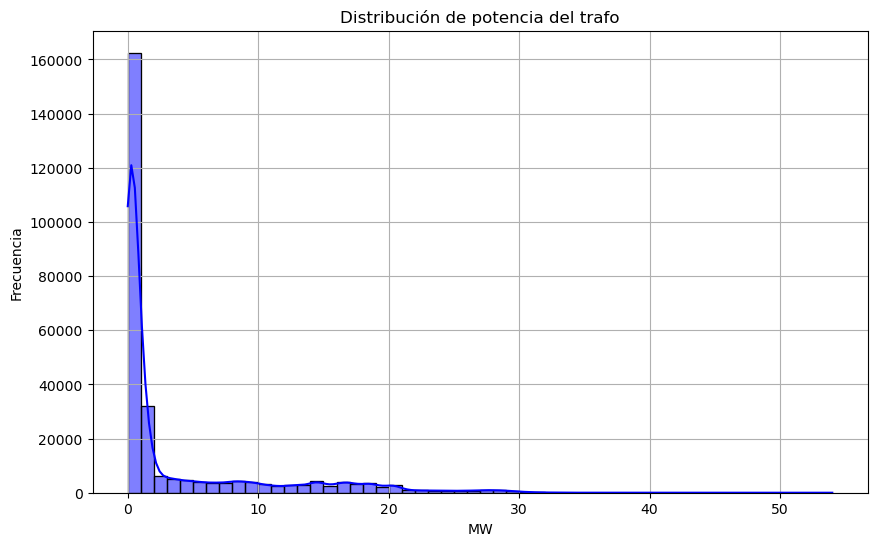

In [353]:
# Crea un histograma para visualizar la distribución de potencia del trafo
plt.figure(figsize=(10, 6))
sns.histplot(trafo['MW'], binwidth=1, kde=True, color='blue')

# Configuración del gráfico
plt.title('Distribución de potencia del trafo')
plt.xlabel('MW')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Como tenemos la potencia a la que trabaja el trafo y la duración del trabajo, podemos sacar la energía consumida

In [355]:
trafo['MWH'] = trafo['MW']*trafo['DURATION'].dt.total_seconds() / 3600
trafo

,TAP,HEATID,STARTTIME,DURATION,MW,MWH
0,11,6F0020,2016-01-01 18:35:00,0 days 00:00:29,0.500,0.004028
1,17,6F0020,2016-01-01 19:04:00,0 days 00:10:40,16.000,2.844444
2,17,6F0020,2016-01-01 18:55:00,0 days 00:03:00,11.000,0.550000
3,17,6F0020,2016-01-01 18:37:00,0 days 00:13:20,16.750,3.722222
4,17,6F0020,2016-01-01 18:36:00,0 days 00:00:40,0.750,0.008333
...,...,...,...,...,...,...
271683,16,5F8442,2015-12-31 22:17:00,0 days 00:00:10,0.125,0.000347
271684,16,5F8442,2015-12-31 22:04:00,0 days 00:00:10,0.000,0.000000
271685,15,5F8442,2015-12-31 22:32:00,0 days 00:05:30,8.125,0.744792
271686,15,5F8442,2015-12-31 22:29:00,0 days 00:01:31,2.125,0.053715


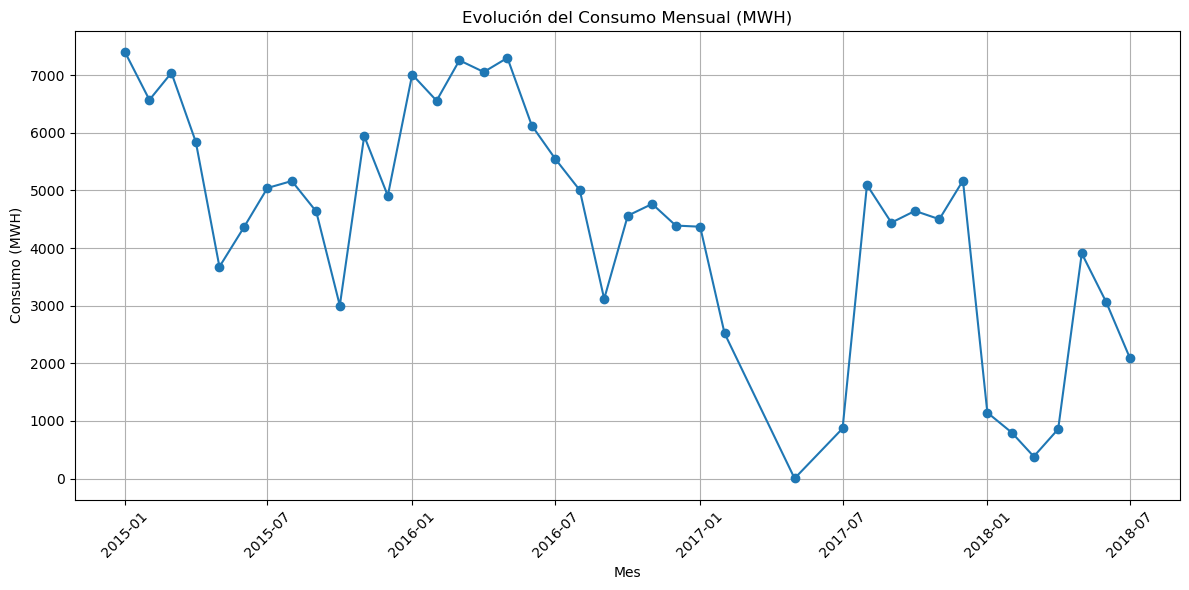

In [356]:
# Agrupa por mes y suma el consumo
trafo['Mes'] = trafo['STARTTIME'].dt.to_period('M')  # Extrae el periodo mensual
consumo_mensual = trafo.groupby('Mes')['MWH'].sum().reset_index()

# Convertimos la columna de Mes a tipo datetime para el gráfico
consumo_mensual['Mes'] = consumo_mensual['Mes'].dt.to_timestamp()

# Graficamos
plt.figure(figsize=(12, 6))
plt.plot(consumo_mensual['Mes'], consumo_mensual['MWH'], marker='o', linestyle='-')
plt.title('Evolución del Consumo Mensual (MWH)')
plt.xlabel('Mes')
plt.ylabel('Consumo (MWH)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

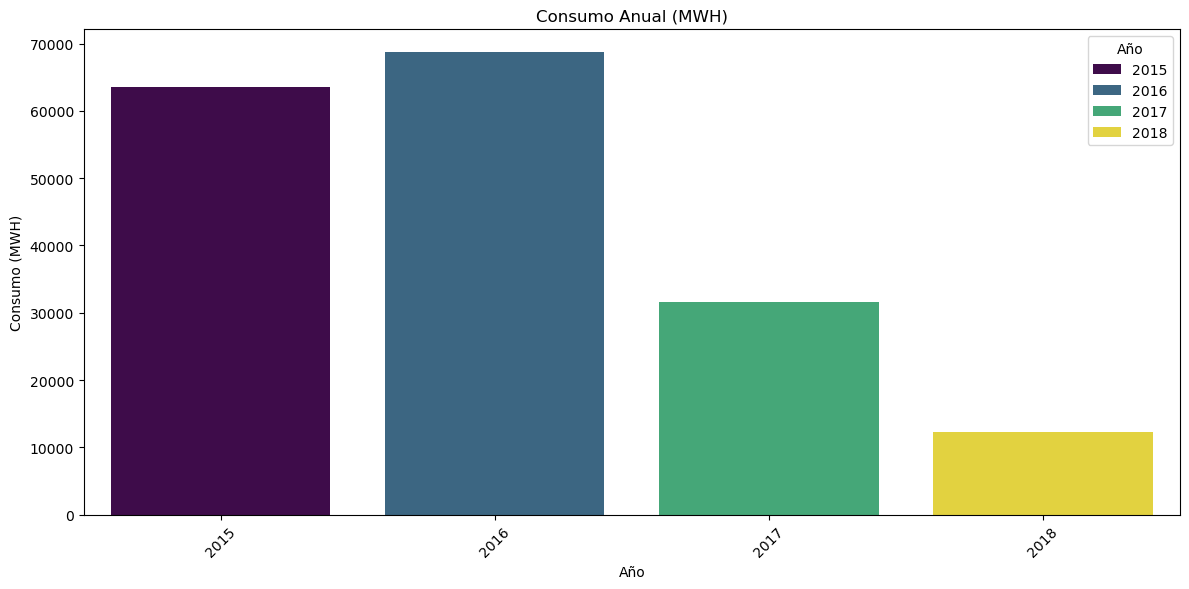

In [357]:
# Extrae el año de la columna STARTTIME
trafo['Año'] = trafo['STARTTIME'].dt.year

# Agrupa por año y suma el consumo
consumo_anual = trafo.groupby('Año')['MWH'].sum().reset_index()

# Graficamos
plt.figure(figsize=(12, 6))
sns.barplot(data=consumo_anual, x='Año', y='MWH', hue='Año', palette='viridis')
plt.title('Consumo Anual (MWH)')
plt.xlabel('Año')
plt.ylabel('Consumo (MWH)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [358]:
# Agrupa por año y suma el consumo
consumo_anual = trafo[trafo['Año'] != 2018].groupby('Año')['MWH'].sum().reset_index()

# Calcula el consumo medio anual
consumo_medio_anual = consumo_anual['MWH'].mean()

# Muestra el consumo medio anual
print(f'Consumo medio anual (excluyendo 2018): {consumo_medio_anual:.2f} MWh')

Consumo medio anual (excluyendo 2018): 54618.51 MWh


## Consumo por TAP

In [360]:
trafo['TAP'].unique()

array([11, 17, 16, 13, 15, 14, 12, 18,  7,  8,  9, 10,  6,  4,  5,  2,  1,
        3], dtype=int64)

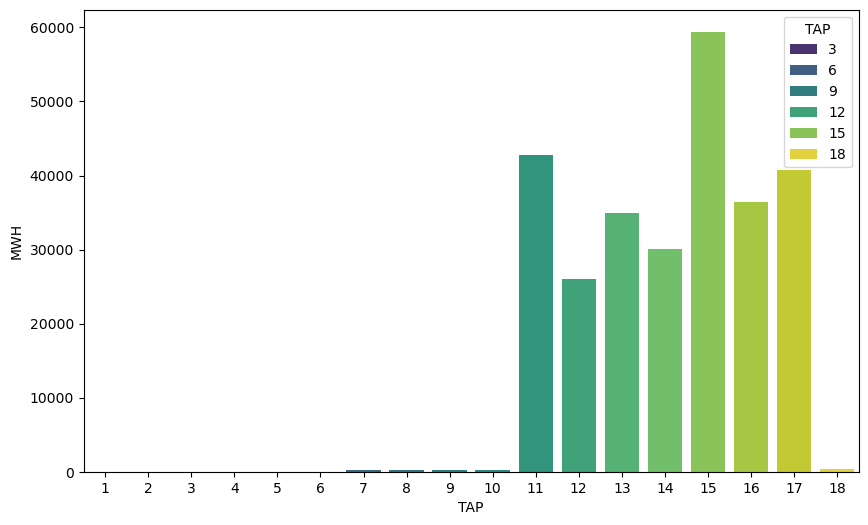

In [361]:
taps_mwh = trafo.groupby('TAP')['MWH'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=taps_mwh, x='TAP', y='MWH', hue='TAP', palette='viridis')

plt.show()

El transformador casi siempre está en estado del 11 al 17

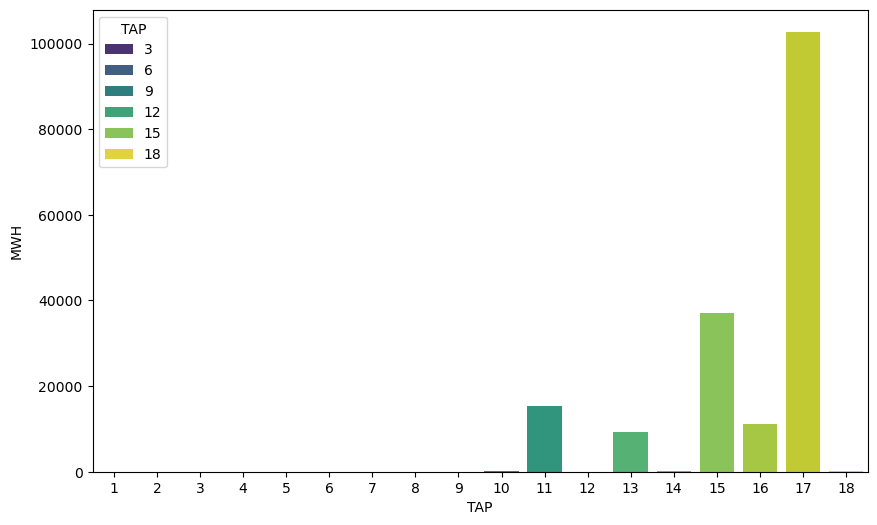

In [363]:
taps_mwh = trafo.groupby('TAP')['MWH'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=taps_mwh, x='TAP', y='MWH', hue='TAP', palette='viridis')

plt.show()

Los estados del transformador que más energía han consumido son el 17 y el 15

<Axes: xlabel='TAP', ylabel='MW'>

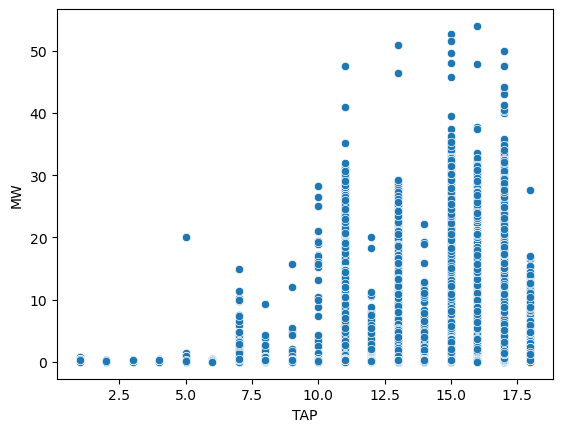

In [365]:
sns.scatterplot(data=trafo, x='TAP', y ='MW')

Los estados mayores suelen tener un consumo mayor pero no hay relación lineal

## Cambio composición acero

In [368]:
# Realizamos un merge para comparar las fechas por HEATID
merged_df = pd.merge(inicial, final, on='HEATID', suffixes=('_inicial', '_final'))

# Comparamos las fechas
merged_df['es_posterior'] = merged_df['DATETIME_inicial'] > merged_df['DATETIME_final']

# Calculamos el porcentaje de veces que la fecha inicial es posterior
porcentaje_posterior = merged_df['es_posterior'].mean() * 100  # Multiplicamos por 100 para obtener el porcentaje

# Mostramos el resultado
total_comparaciones = len(merged_df)
porcentaje_posterior, total_comparaciones

(95.68991319964083, 3341)

Confirmamos que la medida inicial es posterior a la final. Las tablas están mal nombradas desde el origen de la base de datos.

Esto simplemente lo tendremos en cuenta a la hora de saber cuál es la composición final. También lo podemos demostrar con el gráfico que está hecho en el primer apartado del EDA (orden introducción materiales)

Vamos a unir las tablas inicial y final para comparar sus valores

In [371]:
composicion = final.merge(inicial, on='HEATID', how='inner', suffixes=('_inicial', '_final'))

composicion = composicion.drop(['POSITIONROW_inicial', 'POSITIONROW_final'], axis=1)

composicion

,HEATID,DATETIME_inicial,VALC_inicial,VALSI_inicial,VALMN_inicial,VALP_inicial,VALS_inicial,VALCU_inicial,VALCR_inicial,VALMO_inicial,...,DATETIME_final,VALC_final,VALSI_final,VALMN_final,VALP_final,VALS_final,VALCU_final,VALCR_final,VALMO_final,VALNI_final
0,6F0037,2016-01-02 11:02:00,0.0545,0.0197,0.0632,0.0040,0.0210,0.2145,0.0504,0.0165,...,2016-01-02 11:34:00,0.1016,0.1336,0.4486,0.0056,0.0053,0.2176,0.4431,0.0165,0.1337
1,6F0042,2016-01-02 15:22:00,0.0692,0.0167,0.0598,0.0042,0.0158,0.2278,0.0864,0.0166,...,2016-01-02 15:55:00,0.1115,0.0679,0.4126,0.0055,0.0132,0.2201,0.4455,0.0166,0.1675
2,6F0045,2016-01-02 18:05:00,0.0558,0.0169,0.0666,0.0053,0.0203,0.2315,0.1100,0.0176,...,2016-01-02 18:28:00,0.2359,0.2312,1.2189,0.0084,0.0160,0.2330,0.1173,0.0171,0.1761
3,6F0096,2016-01-04 17:30:00,0.0620,0.0156,0.0811,0.0046,0.0211,0.1677,0.0596,0.0112,...,2016-01-04 18:17:00,0.0517,0.2958,1.3216,0.0068,0.0170,0.1712,0.0677,0.0121,0.0958
4,6F0098,2016-01-04 19:19:00,0.0501,0.0144,0.0604,0.0054,0.0251,0.1850,0.0448,0.0111,...,2016-01-04 19:52:00,0.0527,0.3603,1.4401,0.0061,0.0239,0.1822,0.0561,0.0115,0.1021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,5F8427,2015-12-31 00:53:00,0.0819,0.0168,0.0673,0.0048,0.0225,0.2014,0.1249,0.1430,...,2015-12-31 02:10:00,0.1573,0.2098,0.4695,0.0071,0.0121,0.1975,1.9015,0.1568,0.1432
3337,5F8429,2015-12-31 03:58:00,0.0717,0.0376,0.0992,0.0047,0.0234,0.2519,0.0677,0.0224,...,2015-12-31 04:37:00,0.0544,0.1713,0.3549,0.0051,0.0164,0.2585,0.0918,0.0258,0.1205
3338,5F8430,2015-12-31 05:26:00,0.0629,0.0176,0.0640,0.0036,0.0167,0.1751,0.0475,0.0137,...,2016-01-01 06:19:00,0.1709,0.2089,0.4112,0.0053,0.0111,0.2167,0.1532,0.0206,0.1059
3339,5F8431,2015-12-31 06:17:00,0.0718,0.0169,0.0805,0.0053,0.0239,0.1907,0.0565,0.0184,...,2015-12-31 08:32:00,0.1532,0.1274,0.3593,0.0053,0.0173,0.2670,0.1831,0.0304,0.1278


In [372]:
inicial.shape

(20827, 12)

In [373]:
final.shape

(3341, 15)

In [374]:
composicion.shape

(3341, 24)

Creamos nuevas columnas para ver la evolución de cada uno de los componentes a medida que el proceso avanza. De esta manera, entendemos qué elementos suelen aumentar y cuáles suelen reducirse

In [376]:
# Recorre las columnas de 'composicion' y busca columnas que empiecen por 'VAL' con prefijos iguales
for col in composicion.columns:
    # Verifica que la columna tenga el sufijo '_inicial' y comience por 'VAL'
    if '_inicial' in col and col.startswith('VAL'):
        # Obtén el prefijo (nombre antes del '_inicial')
        prefix = col.split('_inicial')[0]
        
        # Construye el nombre de la columna '_final' correspondiente
        final_col = f"{prefix}_final"
        
        # Verifica si la columna '_final' existe
        if final_col in composicion.columns:
            # Calcula la diferencia porcentual y crea una nueva columna con el sufijo '_diferencia'
            composicion[f"{prefix}_diferencia"] = (composicion[final_col] - composicion[col]) * 100 / composicion[col]

composicion.head()

,HEATID,DATETIME_inicial,VALC_inicial,VALSI_inicial,VALMN_inicial,VALP_inicial,VALS_inicial,VALCU_inicial,VALCR_inicial,VALMO_inicial,...,VALNI_final,VALC_diferencia,VALSI_diferencia,VALMN_diferencia,VALP_diferencia,VALS_diferencia,VALCU_diferencia,VALCR_diferencia,VALMO_diferencia,VALNI_diferencia
0,6F0037,2016-01-02 11:02:00,0.0545,0.0197,0.0632,0.0040,0.0210,0.2145,0.0504,0.0165,...,0.1337,86.422018,578.172589,609.810127,40.000000,-74.761905,1.445221,779.166667,0.000000,2.295333
1,6F0042,2016-01-02 15:22:00,0.0692,0.0167,0.0598,0.0042,0.0158,0.2278,0.0864,0.0166,...,0.1675,61.127168,306.586826,589.966555,30.952381,-16.455696,-3.380158,415.625000,0.000000,-0.534442
2,6F0045,2016-01-02 18:05:00,0.0558,0.0169,0.0666,0.0053,0.0203,0.2315,0.1100,0.0176,...,0.1761,322.759857,1268.047337,1730.180180,58.490566,-21.182266,0.647948,6.636364,-2.840909,-1.620112
3,6F0096,2016-01-04 17:30:00,0.0620,0.0156,0.0811,0.0046,0.0211,0.1677,0.0596,0.0112,...,0.0958,-16.612903,1796.153846,1529.593095,47.826087,-19.431280,2.087060,13.590604,8.035714,1.054852
4,6F0098,2016-01-04 19:19:00,0.0501,0.0144,0.0604,0.0054,0.0251,0.1850,0.0448,0.0111,...,0.1021,5.189621,2402.083333,2284.271523,12.962963,-4.780876,-1.513514,25.223214,3.603604,-1.161665


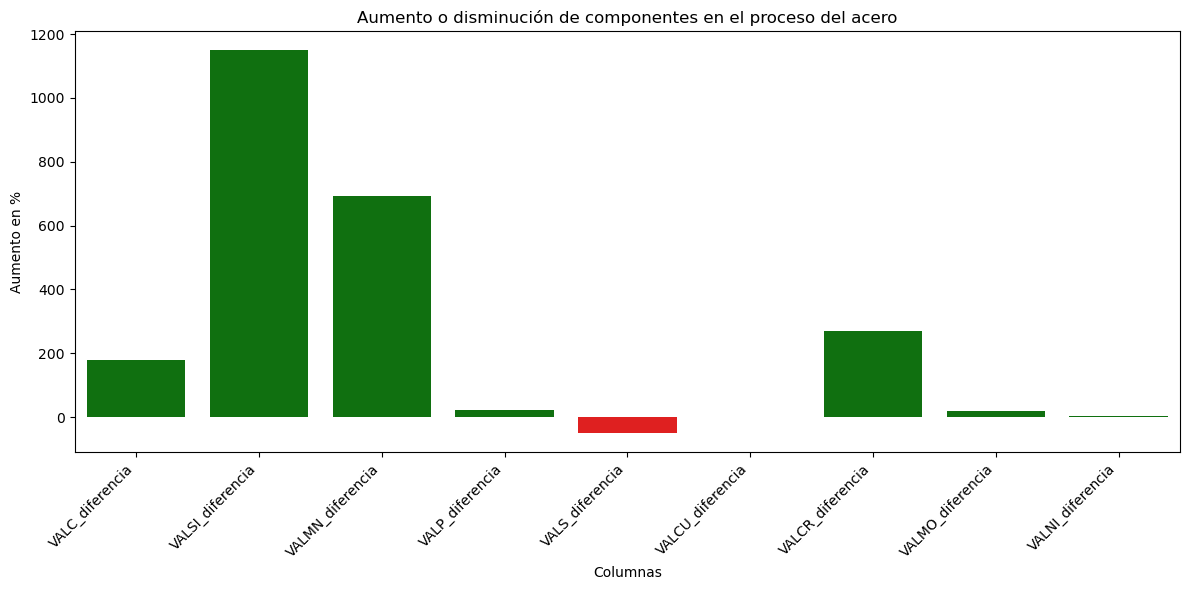

In [377]:
# Filtrar las columnas de diferencia de medida
filtered_columns = [col for col in composicion.columns if col.startswith('VAL') and col.endswith('_diferencia')]

# Calcular el valor medio de cada columna filtrada
mean_values = composicion[filtered_columns].mean()

# Crear un nuevo DataFrame con los datos a graficar
mean_df = mean_values.reset_index()
mean_df.columns = ['Column', 'Mean_Value']  # Renombrar columnas para facilidad

# Definir la paleta de colores personalizada
colors = ['red' if val < 0 else 'green' for val in mean_df['Mean_Value']]

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_df, x='Column', y='Mean_Value',hue='Column', palette=colors)

# Etiquetas y título del gráfico
plt.title('Aumento o disminución de componentes en el proceso del acero')
plt.xlabel('Columnas')
plt.ylabel('Aumento en %')

# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Ajustar el diseño
plt.show()

Vemos que todos los componentes crecen en porcentaje a excepción del `azufre` (S).

Los dos componentes que más aumentan son el `silicio` y el `manganeso`

# 3. MACHINE LEARNING

Tener cerca este gráfico es importante para no olvidar el orden de los procesos

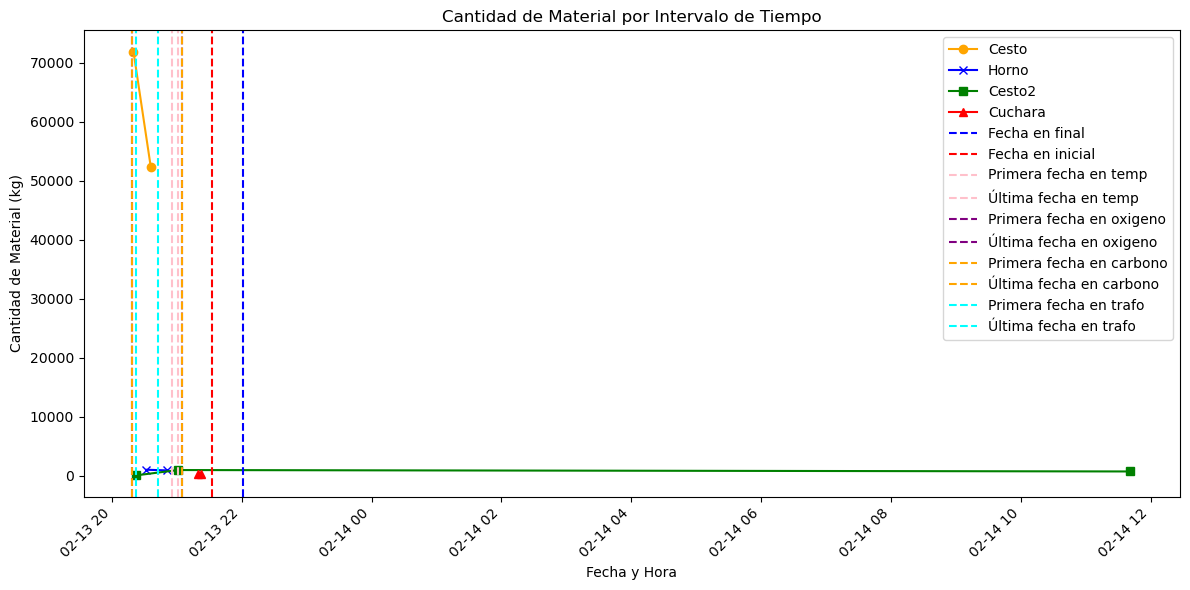

In [381]:
# Obtener un valor aleatorio de HEATID
heatid = random.choice(final['HEATID'].unique())

# Agrupar por 'DATETIME' y sumar los valores de cada grupo
agrupado1 = cesto.loc[cesto['HEATID'] == heatid].groupby('DATETIME')['CHARGED_AMOUNT'].sum()
agrupado2 = horno.loc[horno['HEATID'] == heatid].groupby('DATETIME')['CHARGE_AMOUNT'].sum()
agrupado3 = cesto2.loc[cesto2['HEATID'] == heatid].groupby('DATETIME')['CHARGE_AMOUNT'].sum()
agrupado4 = cuchara.loc[cuchara['HEATID'] == heatid].groupby('FILTER_KEY_DATE')['MAT_CHARGED'].sum()

# Obtener las fechas de 'final' e 'inicial' para ese HEATID, si existen
datetime_final = final.loc[final['HEATID'] == heatid, 'DATETIME']
datetime_inicial = inicial.loc[inicial['HEATID'] == heatid, 'DATETIME']
datetime_final_valid = datetime_final.iloc[0] if not datetime_final.empty else None
datetime_inicial_valid = datetime_inicial.iloc[0] if not datetime_inicial.empty else None

# Obtener la primera y última fecha de la tabla temp para el mismo HEATID
temp_dates = temp.loc[temp['HEATID'] == heatid, 'DATETIME']
first_temp_date = temp_dates.min() if not temp_dates.empty else None
last_temp_date = temp_dates.max() if not temp_dates.empty else None

# Obtener la primera y última fecha de REVTIME en la tabla oxigeno para el mismo HEATID
oxigeno_dates = oxigeno.loc[oxigeno['HEATID'] == heatid, 'REVTIME']
first_oxigeno_date = oxigeno_dates.min() if not oxigeno_dates.empty else None
last_oxigeno_date = oxigeno_dates.max() if not oxigeno_dates.empty else None

# Obtener la primera y última fecha de REVTIME en la tabla carbono para el mismo HEATID
carbono_dates = carbono.loc[carbono['HEATID'] == heatid, 'REVTIME']
first_carbono_date = carbono_dates.min() if not carbono_dates.empty else None
last_carbono_date = carbono_dates.max() if not carbono_dates.empty else None

# Obtener la primera y última fecha de STARTTIME en la tabla trafo para el mismo HEATID
trafo_dates = trafo.loc[trafo['HEATID'] == heatid, 'STARTTIME']
first_trafo_date = trafo_dates.min() if not trafo_dates.empty else None
last_trafo_date = trafo_dates.max() if not trafo_dates.empty else None

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Graficar cada conjunto de datos con un color diferente
plt.plot(agrupado1.index, agrupado1.values, label='Cesto', color='orange', marker='o')
plt.plot(agrupado2.index, agrupado2.values, label='Horno', color='blue', marker='x')
plt.plot(agrupado3.index, agrupado3.values, label='Cesto2', color='green', marker='s')
plt.plot(agrupado4.index, agrupado4.values, label='Cuchara', color='red', marker='^')

# Añadir las líneas verticales si las fechas son válidas
if datetime_final_valid is not None:
    plt.axvline(x=datetime_final_valid, color='blue', linestyle='--', label='Fecha en final')

if datetime_inicial_valid is not None:
    plt.axvline(x=datetime_inicial_valid, color='red', linestyle='--', label='Fecha en inicial')

# Añadir las líneas verticales para la primera y última fecha de temp si existen
if first_temp_date is not None:
    plt.axvline(x=first_temp_date, color='pink', linestyle='--', label='Primera fecha en temp')

if last_temp_date is not None:
    plt.axvline(x=last_temp_date, color='pink', linestyle='--', label='Última fecha en temp')

# Añadir las líneas verticales para la primera y última fecha de REVTIME en oxigeno
if first_oxigeno_date is not None:
    plt.axvline(x=first_oxigeno_date, color='purple', linestyle='--', label='Primera fecha en oxigeno')

if last_oxigeno_date is not None:
    plt.axvline(x=last_oxigeno_date, color='purple', linestyle='--', label='Última fecha en oxigeno')

# Añadir las líneas verticales para la primera y última fecha de REVTIME en carbono
if first_carbono_date is not None:
    plt.axvline(x=first_carbono_date, color='orange', linestyle='--', label='Primera fecha en carbono')

if last_carbono_date is not None:
    plt.axvline(x=last_carbono_date, color='orange', linestyle='--', label='Última fecha en carbono')

# Añadir las líneas verticales para la primera y última fecha de STARTTIME en trafo
if first_trafo_date is not None:
    plt.axvline(x=first_trafo_date, color='aqua', linestyle='--', label='Primera fecha en trafo')

if last_trafo_date is not None:
    plt.axvline(x=last_trafo_date, color='aqua', linestyle='--', label='Última fecha en trafo')

# Añadir etiquetas y título
plt.xlabel('Fecha y Hora')  # Etiqueta eje X
plt.ylabel('Cantidad de Material (kg)')  # Etiqueta eje Y
plt.title('Cantidad de Material por Intervalo de Tiempo')  # Título del gráfico

# Ajustar el formato del eje X para mostrar correctamente las fechas
plt.xticks(rotation=45, ha='right')

# Añadir una leyenda para diferenciar las series
plt.legend()

# Mostrar el gráfico
plt.tight_layout()  # Ajusta el gráfico para que no se corten las etiquetas
plt.show()

## 3.1 Predicción de la composición final Carbono

Vamos a intentar hacer una predicción de los valores finales en función de todos los demás datos que tenemos, pero reduciendo todo a una tabla:
* Con una fila por cada `HEATID` = lote
* Las mediciones de las tablas inicial y final se quedarán intactas
* Las cantidades de materias prima se reducirán a x tipos distintos. Se cogerán los más importantes y el resto se sumarán en 'otros'
* Los valores de oxígeno y carbono añadido se sumarán
* Se cogerá el valor medio de medición de temperatura y oxidación
* Se cogerá el consumo energético por cada lote

Tenemos que tener en cuenta que los componentes `Arsénico`, `Estaño` y `Nitrógeno` solo existen en la tabla final, que es la de las mediciones iniciales, por lo tanto podemos entender que desaparecen en el proceso. Miraremos solo la evolución del resto de componentes que permanecen en la mezcla

### Selección de materias primas

Para empezar, vamos a ver qué materias primas tenemos que seleccionar

In [387]:
# Contamos la cantidad de HEATID únicos en los que aparece cada MAT_CODE
mat_code_counts = materiasprimas.groupby('MAT_CODE')['HEATID'].nunique().reset_index()

# Obtenemos el total de HEATID únicos en la tabla
total_heatids = materiasprimas['HEATID'].nunique()

# Calculamos el porcentaje de aparición de cada MAT_CODE
mat_code_counts['PERCENTAGE'] = (mat_code_counts['HEATID'] / total_heatids) * 100

# Ordenamos por el porcentaje de aparición en orden descendente
mat_code_counts_sorted = mat_code_counts.sort_values(by='PERCENTAGE', ascending=False)

# Mostramos el resultado
mat_code_counts_sorted[['MAT_CODE', 'PERCENTAGE']].head(10)

,MAT_CODE,PERCENTAGE
58,205051,99.870361
6,202007,99.020502
47,203068,98.708407
60,205069,84.692947
86,360258,74.792337
109,705043,67.815816
67,205180,62.361358
110,705046,58.068853
48,203085,49.637490
59,205065,41.316560


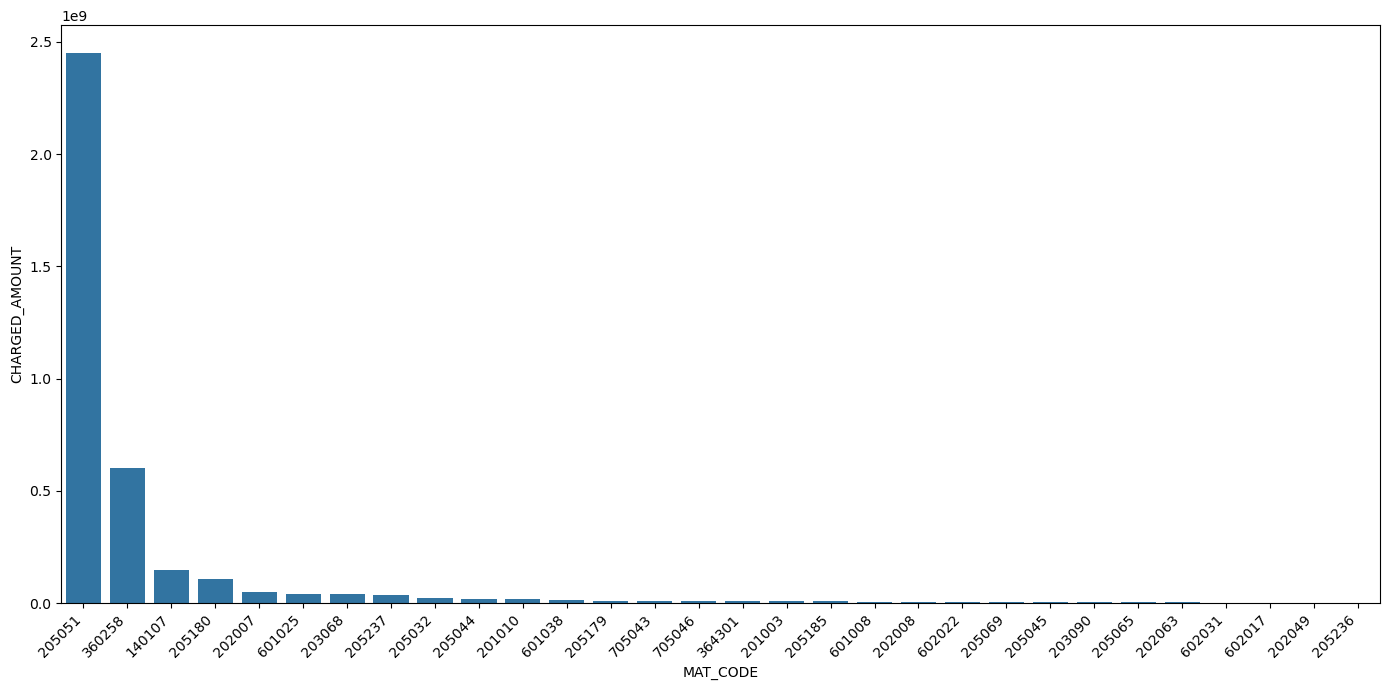

In [388]:
# Filtrar los 30 valores más altos
top_30_materiasprimas = materiasprimas_agrupadas.sort_values(by='CHARGED_AMOUNT', ascending=False).head(30)

# Gráfico de barras ordenado
plt.figure(figsize=(14, 7))  # Ajustar el tamaño de la figura para mejor visibilidad
sns.barplot(
    data=top_30_materiasprimas,
    x='MAT_CODE',
    y='CHARGED_AMOUNT',
    order=top_30_materiasprimas['MAT_CODE']  # Ordenar en el gráfico según los 30 valores más altos
)
plt.xticks(rotation=45, ha='right')  # Girar etiquetas del eje x para mejor legibilidad
plt.tight_layout()  # Acomodar el diseño para que no se sobrepongan los elementos
plt.show()

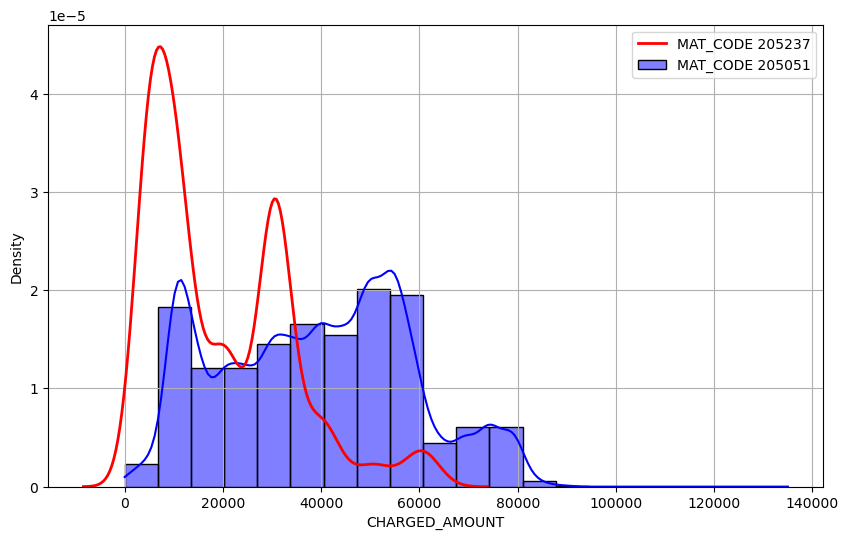

In [389]:
# Filtra los datos para MAT_CODE 205051 y 205180
filtered_data_205051 = cesto[cesto['MAT_CODE'] == 205051]
filtered_data_205237 = cesto[cesto['MAT_CODE'] == 205237]

# Crea el histograma y la curva de densidad para 205051
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data_205051['CHARGED_AMOUNT'], bins=20, kde=True, stat='density', color='blue', label='MAT_CODE 205051')

# Agrega la curva de densidad para 205180 sobre el mismo gráfico
sns.kdeplot(filtered_data_205237['CHARGED_AMOUNT'], color='red', label='MAT_CODE 205237', linewidth=2)

# Configuración del gráfico
plt.xlabel('CHARGED_AMOUNT')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

Vamos a escoger como principales las materias primas que se introducen más de un 75% de las veces, el resto las agrupamos en 'otros'.

Por lo tanto, nos quedamos con: `205051`, `202007`, `203068`, `205069`

A todos los demás, les asignamos el 000000

In [391]:
materiasprimas0 = materiasprimas.copy()

materiasprimas0['MAT_CODE'] = np.where(
    materiasprimas0['MAT_CODE'].isin([205051, 202007, 203068, 205069]),
    materiasprimas0['MAT_CODE'],
    000000 
)

In [392]:
materiasprimas0['MAT_CODE'].unique()

array([     0, 202007, 203068, 205051, 205069], dtype=int64)

In [393]:
materiasprimas0.shape

(636899, 3)

In [394]:
heatids_final = final['HEATID'].unique()
materiasprimas0 = materiasprimas0[materiasprimas0['HEATID'].isin(heatids_final)]
materiasprimas0.shape

(105241, 3)

In [395]:
materiasprimas0 = materiasprimas0.groupby(['HEATID','MAT_CODE'])['CHARGED_AMOUNT'].sum().reset_index()

Vamos a pivotar la tabla para que cada fila corresponda a un único HEATID, y ya habremos terminado de preparar las 4 tablas de carga de materiales

In [397]:
materiasprimas0 = materiasprimas0.pivot_table(
    index='HEATID', 
    columns='MAT_CODE', 
    values='CHARGED_AMOUNT', 
    aggfunc='sum', 
    fill_value=0 
).reset_index()  

materiasprimas0.head()

MAT_CODE,HEATID,0,202007,203068,205051,205069
0,5F0003,26856.00,726.0,565.0,108033.0,140.0
1,5F0227,42900.00,566.0,1217.0,116535.0,420.0
2,5F0229,320553.80,15864.0,1419.0,119389.0,6720.0
3,5F0231,40976.42,569.0,1415.0,119773.0,140.0
4,5F0418,70860.00,1598.0,331.0,123373.0,120.0


### Cantidades de oxigeno y carbono

<Axes: xlabel='REVTIME', ylabel='O2_AMOUNT'>

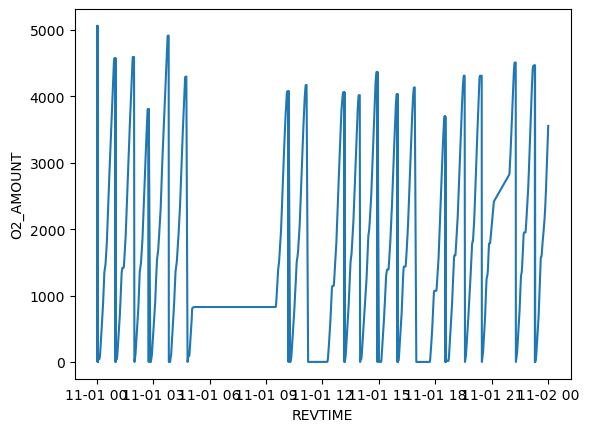

In [399]:
sns.lineplot(data=oxigeno[oxigeno['REVTIME'].dt.date == pd.Timestamp('2015-11-01').date()].sort_values('REVTIME'), x='REVTIME', y='O2_AMOUNT')

<Axes: xlabel='REVTIME', ylabel='O2_AMOUNT'>

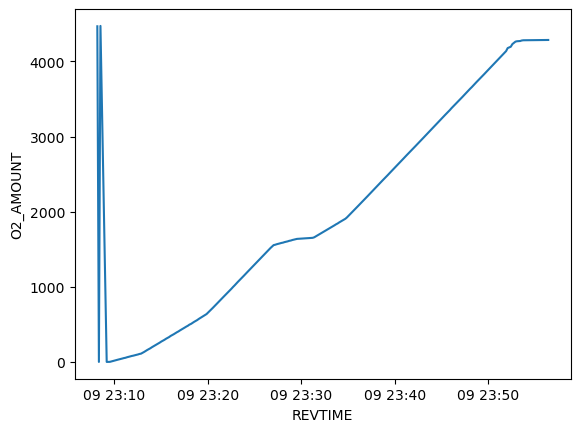

In [400]:
sns.lineplot(data=oxigeno[oxigeno['HEATID']==random.choice(oxigeno['HEATID'].unique())].sort_values('REVTIME'), x='REVTIME', y='O2_AMOUNT')

Vamos a coger el valor máximo de oxigeno y de gas en cada HEATID, porque vemos que va subiendo al valor, hasta que considera que es suficiente.

Entonces saca el lote, mete el siguiente, y baja a cero y vuelve a subir.

El problema que observamos es que esta cantidad de oxígeno tiene cierta inercia. Y cuando el lote entra en el horno aún no se ha evacuado el oxígeno del anterior lote. Poco después, cae en picado

In [402]:
oxigeno0 = oxigeno.copy()

In [403]:
oxigeno0['DURATION'] = oxigeno0.groupby('HEATID')['REVTIME'].transform(lambda x: (x.max() - x.min())/2 + x.min())
oxigeno0

,REVTIME,O2_AMOUNT,GAS_AMOUNT,O2_FLOW,GAS_FLOW,HEATID,DURATION
0,2016-01-01 18:31:46.003,0.0,0.0,0.0,0.0,6F0020,2016-01-01 18:55:46.306500
1,2016-01-01 18:31:55.925,4555.0,548.0,0.0,0.0,6F0020,2016-01-01 18:55:46.306500
2,2016-01-01 18:32:55.972,0.0,0.0,0.0,0.0,6F0020,2016-01-01 18:55:46.306500
3,2016-01-01 18:33:05.956,0.0,0.0,2628.0,0.0,6F0020,2016-01-01 18:55:46.306500
4,2016-01-01 18:33:16.019,1.0,0.0,1077.0,164.0,6F0020,2016-01-01 18:55:46.306500
...,...,...,...,...,...,...,...
5748189,2015-12-31 22:40:26.420,3888.0,537.0,0.0,0.0,5F8442,2015-12-31 22:22:00.799500
5748190,2015-12-31 22:40:36.654,3893.0,537.0,0.0,0.0,5F8442,2015-12-31 22:22:00.799500
5748191,2015-12-31 22:40:46.513,3898.0,537.0,1817.0,83.0,5F8442,2015-12-31 22:22:00.799500
5748192,2015-12-31 22:40:56.482,3903.0,537.0,1971.0,84.0,5F8442,2015-12-31 22:22:00.799500


Nos quedamos solo con los valores de oxigeno y gas desde la mitad del proceso (para evitar la inercia de los primeros momentos correspondiente al lote anterior), y de esos seleccionamos el maximo. 

In [405]:
condition = oxigeno0['REVTIME'] >= oxigeno0['DURATION']
oxigeno0 = oxigeno0[condition]

In [406]:
oxigeno0 = oxigeno0.groupby('HEATID')[['O2_AMOUNT', 'GAS_AMOUNT']].max()

Ahora vamos a hacer lo mismo con la tabla `carbono` y después las unimos

<Axes: xlabel='REVTIME', ylabel='INJ_AMOUNT_CARBON'>

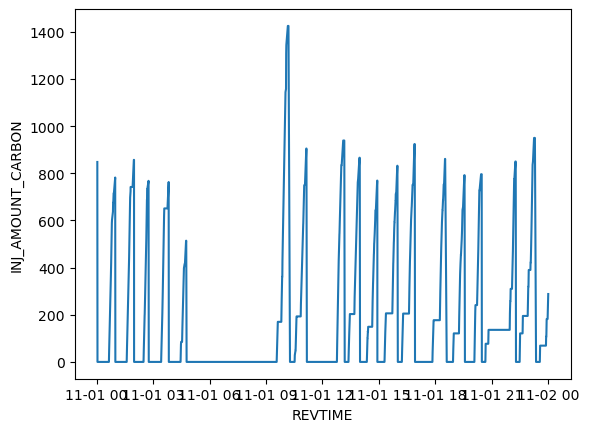

In [408]:
sns.lineplot(data=carbono[carbono['REVTIME'].dt.date == pd.Timestamp('2015-11-01').date()].sort_values('REVTIME'), x='REVTIME', y='INJ_AMOUNT_CARBON')

<Axes: xlabel='REVTIME', ylabel='INJ_AMOUNT_CARBON'>

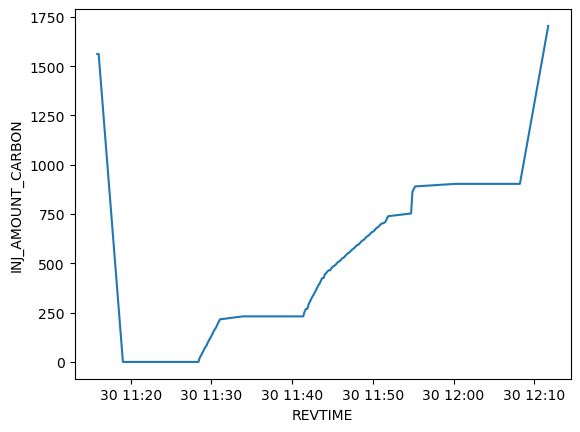

In [409]:
sns.lineplot(data=carbono[carbono['HEATID']==random.choice(carbono['HEATID'].unique())].sort_values('REVTIME'), x='REVTIME', y='INJ_AMOUNT_CARBON')

In [410]:
carbono0 = carbono.copy()
carbono0['DURATION'] = carbono0.groupby('HEATID')['REVTIME'].transform(lambda x: (x.max() - x.min())/2 + x.min())
condition = carbono0['REVTIME'] >= carbono0['DURATION']
carbono0 = carbono0[condition]
carbono0 = carbono0.groupby('HEATID')['INJ_AMOUNT_CARBON'].max().reset_index()
carbono0.rename(columns={'INJ_AMOUNT_CARBON': 'CARBON_AMOUNT'}, inplace=True)
carbono0

,HEATID,CARBON_AMOUNT
0,5F0002,1021.0
1,5F0003,957.0
2,5F0004,789.0
3,5F0005,812.0
4,5F0006,882.0
...,...,...
20822,8F5227,741.0
20823,8F5392,1163.0
20824,8F5471,1715.0
20825,8F5472,906.0


### Mediciones de temperatura y oxidación

<Axes: xlabel='DATETIME', ylabel='TEMP'>

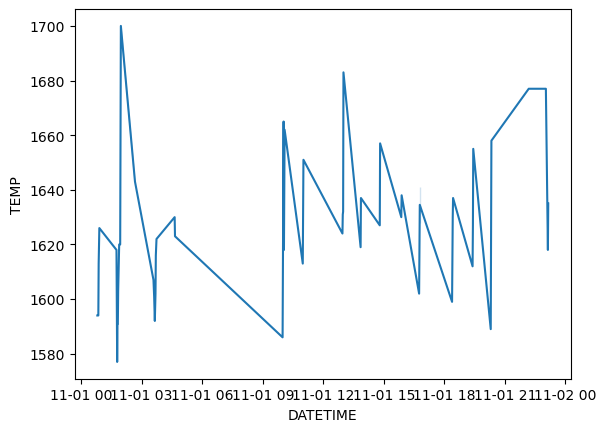

In [412]:
sns.lineplot(data=temp[temp['DATETIME'].dt.date == pd.Timestamp('2015-11-01').date()].sort_values('DATETIME'), x='DATETIME', y='TEMP')

<Axes: xlabel='DATETIME', ylabel='VALO2_PPM'>

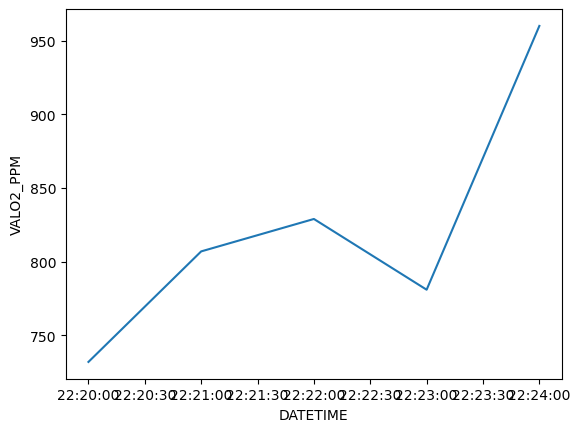

In [413]:
sns.lineplot(data=temp[temp['HEATID']==random.choice(temp['HEATID'].unique())].sort_values('DATETIME'), x='DATETIME', y='VALO2_PPM')

En el caso de la temperatura y oxidación cogeremos la media

In [415]:
temp0 = temp.groupby('HEATID')[['VALO2_PPM', 'TEMP']].apply(lambda x: x[x != 0].mean())

### Gasto energético en el horno

La suma total del consumo energético de cada lote

In [418]:
trafo0 = trafo.groupby('HEATID')['MWH'].sum().reset_index()

### Unimos tablas

In [420]:
tabla0 = final.drop(columns= ['POSITIONROW', 'DATETIME']).merge(
    inicial[['HEATID', 'VALC']], on='HEATID', how='inner', suffixes=('_i', '_f')).merge(
    materiasprimas0, on='HEATID', how='inner').merge(
    oxigeno0, on='HEATID', how='inner').merge(
    carbono0, on='HEATID', how='inner').merge(
    temp0, on='HEATID', how='inner').merge(
    trafo0, on='HEATID', how='inner')

tabla0.head()

,HEATID,VALC_i,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,...,202007,203068,205051,205069,O2_AMOUNT,GAS_AMOUNT,CARBON_AMOUNT,VALO2_PPM,TEMP,MWH
0,6F0037,0.0545,0.0197,0.0632,0.0040,0.0210,0.2145,0.0504,0.0165,0.1307,...,550.0,919.0,113831.0,200.0,4840.0,840.0,707.0,982.40,1633.500000,5.727153
1,6F0042,0.0692,0.0167,0.0598,0.0042,0.0158,0.2278,0.0864,0.0166,0.1684,...,569.0,917.0,108792.0,200.0,4694.0,627.0,639.0,1485.00,1636.000000,5.781389
2,6F0045,0.0558,0.0169,0.0666,0.0053,0.0203,0.2315,0.1100,0.0176,0.1790,...,2170.0,265.0,427378.0,0.0,2949.0,517.0,412.0,1006.50,1609.666667,4.718056
3,6F0096,0.0620,0.0156,0.0811,0.0046,0.0211,0.1677,0.0596,0.0112,0.0948,...,0.0,237.0,106225.0,180.0,5318.0,649.0,1076.0,1102.00,1636.714286,7.960729
4,6F0098,0.0501,0.0144,0.0604,0.0054,0.0251,0.1850,0.0448,0.0111,0.1033,...,0.0,239.0,97713.0,135.0,4895.0,603.0,763.0,608.25,1653.800000,5.541910


In [421]:
tabla0.shape

(3337, 25)

In [422]:
tabla0.rename(columns={
    205069: 'ALUMINIO',
    205051: '3A',
    203068: 'COKE',
    202007: 'MANGANESO_SI',
    0: 'OTRO'
}, inplace=True)

### Creamos modelo

In [424]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

#### Limpieza

In [426]:
tabla0.isnull().sum()

HEATID           0
VALC_i           0
VALSI            0
VALMN            0
VALP             0
VALS             0
VALCU            0
VALCR            0
VALMO            0
VALNI            0
VALAS            0
VALSN            0
VALN             0
VALC_f           0
OTRO             0
MANGANESO_SI     0
COKE             0
3A               0
ALUMINIO         0
O2_AMOUNT        0
GAS_AMOUNT       0
CARBON_AMOUNT    0
VALO2_PPM        3
TEMP             0
MWH              0
dtype: int64

Eliminamos las filas con nulos


In [428]:
tabla0 = tabla0.dropna(subset=['VALO2_PPM'])

#### Separacion de variables

In [430]:
X = tabla0.drop(columns=['VALC_f','HEATID'])  # Eliminamos las columnas no relevantes
y = tabla0['VALC_f']

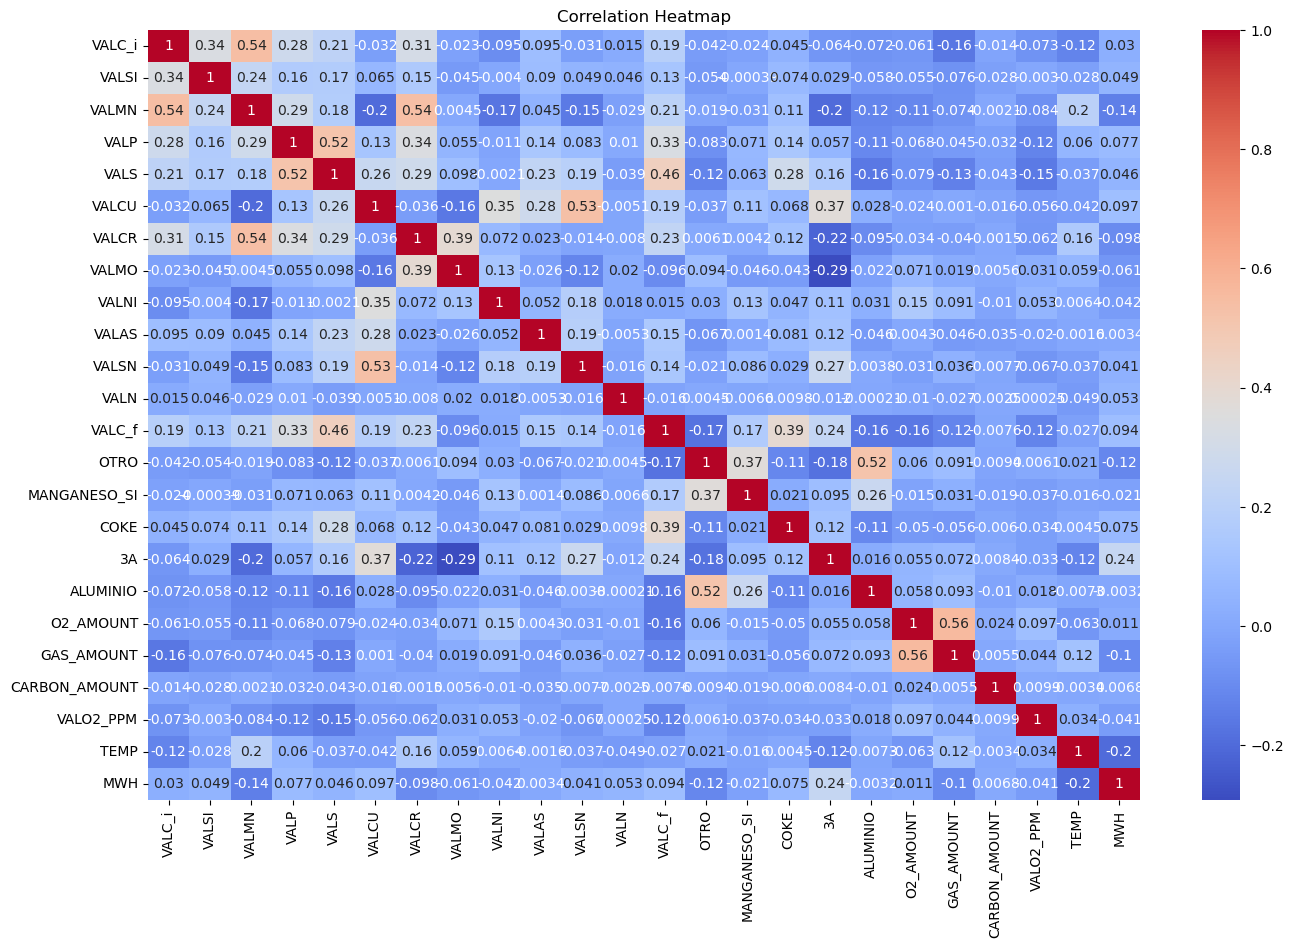

In [431]:
correlation_matrix = tabla0.drop(columns='HEATID').corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

#### Normalización datos

In [433]:
Xnorm = X.copy()
Xnorm = (Xnorm-Xnorm.min())/(Xnorm.max()-Xnorm.min())
Xnorm.describe()

,VALC_i,VALSI,VALMN,VALP,VALS,VALCU,VALCR,VALMO,VALNI,VALAS,...,MANGANESO_SI,COKE,3A,ALUMINIO,O2_AMOUNT,GAS_AMOUNT,CARBON_AMOUNT,VALO2_PPM,TEMP,MWH
count,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,...,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,0.141565,0.080167,0.159849,0.069130,0.235994,0.264513,0.097508,0.077748,0.124051,0.197349,...,0.039744,0.074977,0.212807,0.009658,0.218375,0.126177,0.026383,0.122607,0.450010,0.409550
std,0.076366,0.040538,0.081404,0.047056,0.118183,0.065434,0.071320,0.123485,0.057419,0.047681,...,0.056711,0.041436,0.046658,0.027588,0.031221,0.033637,0.119017,0.099139,0.118384,0.114376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.092254,0.064583,0.107173,0.043429,0.143542,0.229310,0.055385,0.029868,0.091114,0.172589,...,0.014503,0.049547,0.195288,0.000000,0.201584,0.105629,0.008484,0.082903,0.367583,0.332902
50%,0.129388,0.073181,0.144515,0.057143,0.220989,0.262803,0.082564,0.039887,0.112991,0.197970,...,0.026043,0.076999,0.222728,0.005252,0.214530,0.119334,0.011231,0.101192,0.443695,0.399137
75%,0.177256,0.084851,0.195148,0.083429,0.309788,0.298354,0.119316,0.057467,0.143663,0.218274,...,0.053229,0.093969,0.239230,0.010504,0.230941,0.141682,0.014694,0.121059,0.523266,0.475282
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Selección de variables relevantes

Voy a probar un RFE (Recursive Feature Elimination) con regresión lineal y luego con SVR (Support Vector Regression).

In [436]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()                          #configurar modelo lineal
rfe = RFE(estimator=model, n_features_to_select=10)  #configurar RFE
rfe = rfe.fit(Xnorm, y)                               #ajustar RFE a mis datos

seleccionadas = Xnorm.columns[rfe.support_]
print("Variables seleccionadas:", seleccionadas)

Variables seleccionadas: Index(['VALP', 'VALS', 'VALCR', 'VALMO', 'OTRO', 'MANGANESO_SI', 'COKE', '3A',
       'ALUMINIO', 'O2_AMOUNT'],
      dtype='object')


Ahora con SVR, que permite capturar relaciones complejas (no lineales) entre las variables predictoras y la variable objetivo

In [438]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


svr_model = SVR(kernel='linear')                                  #configurar modelo SVR
rfe_svr = RFE(estimator=svr_model, n_features_to_select=10)       #configurar RFE con SVR
rfe_svr = rfe_svr.fit(Xnorm, y)                                            #ajustar

seleccionadas_svr = Xnorm.columns[rfe_svr.support_]
print("Variables seleccionadas con SVR:", seleccionadas_svr)

Variables seleccionadas con SVR: Index(['VALC_i', 'VALS', 'VALCR', 'VALMO', 'OTRO', 'MANGANESO_SI', 'COKE',
       '3A', 'ALUMINIO', 'O2_AMOUNT'],
      dtype='object')


Ahora comparamos ambos RFE, para ver cuál es más adecuado

In [440]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Usar las variables seleccionadas por RFE con regresión lineal
X_selected_linear = Xnorm[seleccionadas]

# Usar las variables seleccionadas por RFE con SVR
X_selected_svr = Xnorm[seleccionadas_svr]

# Modelo 1: Random Forest con variables seleccionadas por RFE con regresión lineal
rf_model = RandomForestRegressor()
rf_model.fit(X_selected_linear, y)
y_pred_linear = rf_model.predict(X_selected_linear)

# Modelo 2: Random Forest con variables seleccionadas por RFE con SVR
rf_model.fit(X_selected_svr, y)
y_pred_svr = rf_model.predict(X_selected_svr)

# Métricas
mse_linear = mean_squared_error(y, y_pred_linear)
mse_svr = mean_squared_error(y, y_pred_svr)
r2_linear = r2_score(y, y_pred_linear)
r2_svr = r2_score(y, y_pred_svr)

print(f"Resultados RFE con regresión lineal: MSE={mse_linear}, R2={r2_linear}")
print(f"Resultados RFE con SVR: MSE={mse_svr}, R2={r2_svr}")

Resultados RFE con regresión lineal: MSE=0.00031548024682813446, R2=0.9620653277399941
Resultados RFE con SVR: MSE=0.00031259696864277157, R2=0.9624120252403792


Ambos son muy similares, lo que indica que no hay relaciones complejas por detrás entre las variables. Nos vamos a quedar con la seleccion de SVR porque tambien contempla el contenido inicial de Carbono y me parece importante para predecir el contenido final

In [442]:
X_selected = Xnorm[seleccionadas_svr]
X_selected

,VALC_i,VALS,VALCR,VALMO,OTRO,MANGANESO_SI,COKE,3A,ALUMINIO,O2_AMOUNT
0,0.095445,0.110999,0.038291,0.041210,0.039302,0.014295,0.042436,0.224886,0.010504,0.247111
1,0.138091,0.058527,0.099829,0.041588,0.019386,0.014789,0.042344,0.214931,0.010504,0.239300
2,0.099217,0.103935,0.140171,0.045369,0.086459,0.056400,0.012237,0.844334,0.000000,0.145945
3,0.117203,0.112008,0.054017,0.021172,0.018557,0.000000,0.010944,0.209859,0.009454,0.272684
4,0.082681,0.152371,0.028718,0.020794,0.018356,0.000000,0.011036,0.193043,0.007090,0.250053
...,...,...,...,...,...,...,...,...,...,...
3332,0.174935,0.126135,0.165641,0.519471,0.021775,0.015984,0.062385,0.155115,0.006303,0.184731
3333,0.145344,0.135217,0.067863,0.063516,0.017563,0.013125,0.046685,0.234778,0.000000,0.190402
3334,0.119814,0.067608,0.033333,0.030624,0.067860,0.043665,0.046685,0.254801,0.014181,0.213353
3335,0.145634,0.140262,0.048718,0.048393,0.002958,0.013463,0.055874,0.256067,0.000000,0.215172


#### Modelo

In [444]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.25,
    random_state=42
)

El modelo queda optimizado con un R2 de 0.74

In [446]:
# Crear el modelo
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [447]:
y_pred = rf_model.predict(X_test)

# Evaluar el desempeño
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")

MSE: 0.002
R2: 0.742


Vamos a ver qué importancia ha tenido cada variable en el modelo

        Feature  Importance
6          COKE    0.318371
5  MANGANESO_SI    0.310460
8      ALUMINIO    0.085922
4          OTRO    0.054537
7            3A    0.051972
1          VALS    0.051430
2         VALCR    0.037031
3         VALMO    0.032589
0        VALC_i    0.028895
9     O2_AMOUNT    0.028793


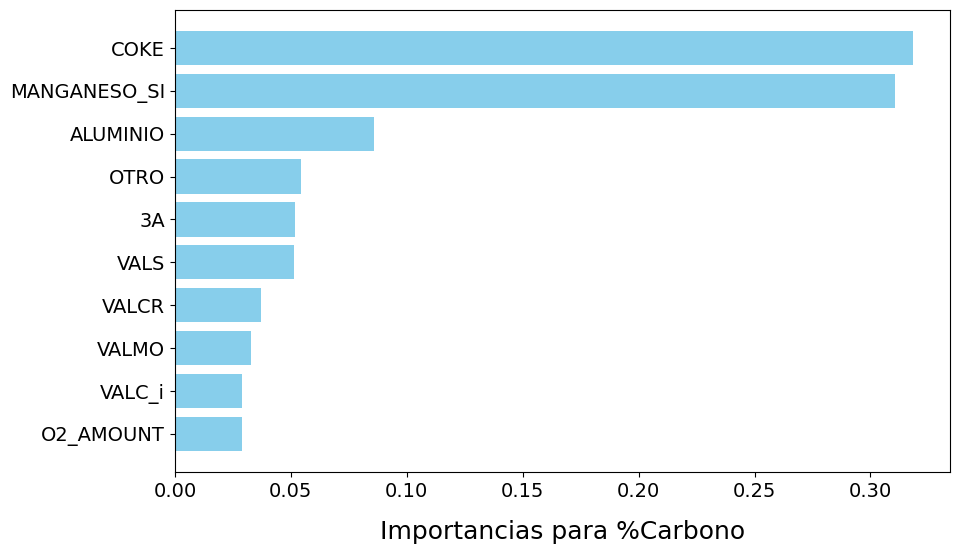

In [449]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X_selected.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invertir el eje para que la más importante esté arriba

plt.xlabel('Importancias para %Carbono', fontsize=18, labelpad=14)
plt.tick_params(axis='both', which='major', labelsize=14)  # Tamaño de las etiquetas
plt.show()

#### Optimizar modelo

In [451]:
# 2. Definir los hiperparámetros para buscar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
}

# 3. Realizar la búsqueda de hiperparámetros (solo con el conjunto de entrenamiento)
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# 4. Imprimir los mejores hiperparámetros
print("Best Parameters:", grid_search.best_params_)

# 5. Crear el modelo con los mejores hiperparámetros
best_rf_model = grid_search.best_estimator_

# 6. Entrenar el modelo definitivo
best_rf_model.fit(X_train, y_train)

# 7. Realizar predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)

# 8. Evaluar el desempeño
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
MSE: 0.002
R2: 0.740


## 3.2 Predicción composición Azufre

Para la composición del Azufre vamos a tener en cuenta más materias primas en lugar de agruparlas todas al principio.

Además, escogeremos las materias primas que técnicamente influirían más en el contenido en azufre, además de las más utilizadas.

In [454]:
materiasprimas1 = materiasprimas.copy()

materiasprimas1['MAT_CODE'] = np.where(
    materiasprimas1['MAT_CODE'].isin([205051, 202007, 203068, 205069,202027,202008,201010,364300,140107]),
    materiasprimas1['MAT_CODE'],
    000000 
)

In [455]:
heatids_final = final['HEATID'].unique()
materiasprimas1 = materiasprimas1[materiasprimas1['HEATID'].isin(heatids_final)]

materiasprimas1 = materiasprimas1.groupby(['HEATID','MAT_CODE'])['CHARGED_AMOUNT'].sum().reset_index()

materiasprimas1 = materiasprimas1.pivot_table(
    index='HEATID', 
    columns='MAT_CODE', 
    values='CHARGED_AMOUNT', 
    aggfunc='sum', 
    fill_value=0 
).reset_index()  

materiasprimas1.head()

MAT_CODE,HEATID,0,140107,201010,202007,202008,202027,203068,205051,205069
0,5F0003,11212.00,0.0,15320.0,726.0,324.0,0.0,565.0,108033.0,140.0
1,5F0227,37680.00,0.0,4970.0,566.0,250.0,0.0,1217.0,116535.0,420.0
2,5F0229,318078.80,0.0,2220.0,15864.0,255.0,0.0,1419.0,119389.0,6720.0
3,5F0231,38254.42,0.0,2470.0,569.0,252.0,0.0,1415.0,119773.0,140.0
4,5F0418,70046.00,0.0,0.0,1598.0,814.0,0.0,331.0,123373.0,120.0


In [456]:
tabla1 = final.drop(columns= ['POSITIONROW', 'DATETIME']).merge(
    inicial[['HEATID','VALS']], on='HEATID', how='inner', suffixes=('_i', '_f')).merge(
    materiasprimas1, on='HEATID', how='inner').merge(
    oxigeno0, on='HEATID', how='inner').merge(
    carbono0, on='HEATID', how='inner').merge(
    temp0, on='HEATID', how='inner').merge(
    trafo0, on='HEATID', how='inner')

In [457]:
tabla1.rename(columns={
    205069: 'ALUMINIO',
    205051: '3A',
    203068: 'COKE',
    202007: 'MANGANESO_SI',
    0: 'OTRO',
    364300: 'LIME1',
    140107: 'LIME2',
    201010:'Steelmaking iron',
    202008: 'FeSi65-4',
    202027:'Sulfur wire'
}, inplace=True)

tabla1.head()

,HEATID,VALC,VALSI,VALMN,VALP,VALS_i,VALCU,VALCR,VALMO,VALNI,...,Sulfur wire,COKE,3A,ALUMINIO,O2_AMOUNT,GAS_AMOUNT,CARBON_AMOUNT,VALO2_PPM,TEMP,MWH
0,6F0037,0.0545,0.0197,0.0632,0.0040,0.0210,0.2145,0.0504,0.0165,0.1307,...,0.0,919.0,113831.0,200.0,4840.0,840.0,707.0,982.40,1633.500000,5.727153
1,6F0042,0.0692,0.0167,0.0598,0.0042,0.0158,0.2278,0.0864,0.0166,0.1684,...,0.0,917.0,108792.0,200.0,4694.0,627.0,639.0,1485.00,1636.000000,5.781389
2,6F0045,0.0558,0.0169,0.0666,0.0053,0.0203,0.2315,0.1100,0.0176,0.1790,...,0.0,265.0,427378.0,0.0,2949.0,517.0,412.0,1006.50,1609.666667,4.718056
3,6F0096,0.0620,0.0156,0.0811,0.0046,0.0211,0.1677,0.0596,0.0112,0.0948,...,0.0,237.0,106225.0,180.0,5318.0,649.0,1076.0,1102.00,1636.714286,7.960729
4,6F0098,0.0501,0.0144,0.0604,0.0054,0.0251,0.1850,0.0448,0.0111,0.1033,...,0.0,239.0,97713.0,135.0,4895.0,603.0,763.0,608.25,1653.800000,5.541910


In [458]:
tabla1 = tabla1.dropna(subset=['VALO2_PPM'])

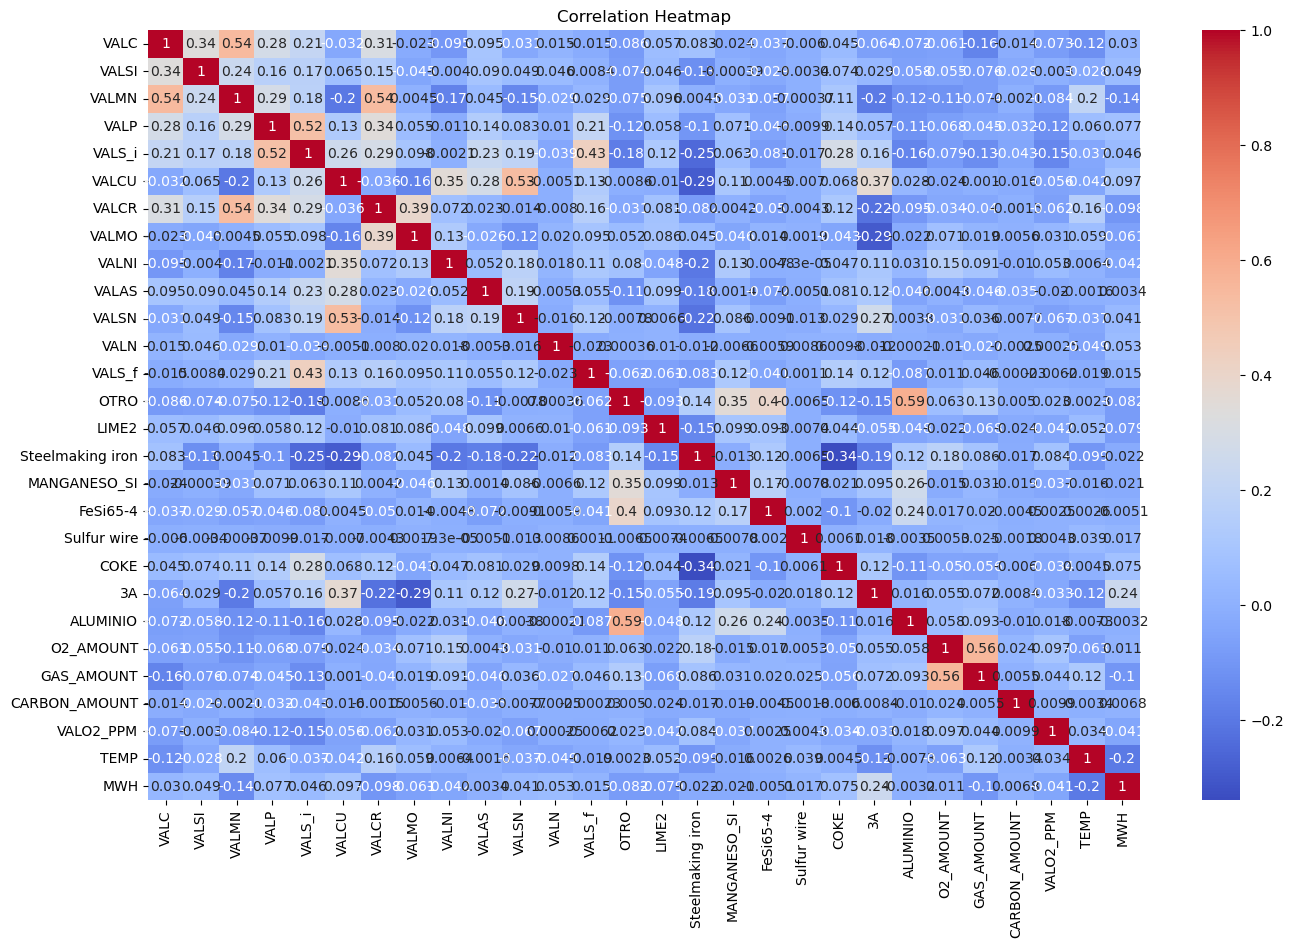

In [459]:
correlation_matrix = tabla1.drop(columns='HEATID').corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [460]:
X = tabla1.drop(columns=['VALS_f','HEATID'])  # Eliminamos las columnas no relevantes
y = tabla1['VALS_f']

In [461]:
Xnorm = X.copy()
Xnorm = (Xnorm-Xnorm.min())/(Xnorm.max()-Xnorm.min())
Xnorm.describe()

,VALC,VALSI,VALMN,VALP,VALS_i,VALCU,VALCR,VALMO,VALNI,VALAS,...,Sulfur wire,COKE,3A,ALUMINIO,O2_AMOUNT,GAS_AMOUNT,CARBON_AMOUNT,VALO2_PPM,TEMP,MWH
count,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,...,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,0.141565,0.080167,0.159849,0.069130,0.235994,0.264513,0.097508,0.077748,0.124051,0.197349,...,0.000310,0.074977,0.212807,0.009658,0.218375,0.126177,0.026383,0.122607,0.450010,0.409550
std,0.076366,0.040538,0.081404,0.047056,0.118183,0.065434,0.071320,0.123485,0.057419,0.047681,...,0.017323,0.041436,0.046658,0.027588,0.031221,0.033637,0.119017,0.099139,0.118384,0.114376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.092254,0.064583,0.107173,0.043429,0.143542,0.229310,0.055385,0.029868,0.091114,0.172589,...,0.000000,0.049547,0.195288,0.000000,0.201584,0.105629,0.008484,0.082903,0.367583,0.332902
50%,0.129388,0.073181,0.144515,0.057143,0.220989,0.262803,0.082564,0.039887,0.112991,0.197970,...,0.000000,0.076999,0.222728,0.005252,0.214530,0.119334,0.011231,0.101192,0.443695,0.399137
75%,0.177256,0.084851,0.195148,0.083429,0.309788,0.298354,0.119316,0.057467,0.143663,0.218274,...,0.000000,0.093969,0.239230,0.010504,0.230941,0.141682,0.014694,0.121059,0.523266,0.475282
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Modelo Random Forest

In [463]:
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")

MSE: 0.000
R2: 0.346


### Modelo Gradient Boosting

In [465]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.2, random_state=42)

# Crear el modelo Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

# Ajustar el modelo a los datos de entrenamiento
gb_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = gb_model.predict(X_test)

# Evaluar el rendimiento
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")

MSE: 0.000
R2: 0.347


Ahora vemos las importancias

         Feature  Importance
4         VALS_i    0.221717
15  MANGANESO_SI    0.074624
13         LIME2    0.046661
20      ALUMINIO    0.040697
22    GAS_AMOUNT    0.038924
3           VALP    0.036952
0           VALC    0.035670
25          TEMP    0.035400
21     O2_AMOUNT    0.035015
18          COKE    0.034121


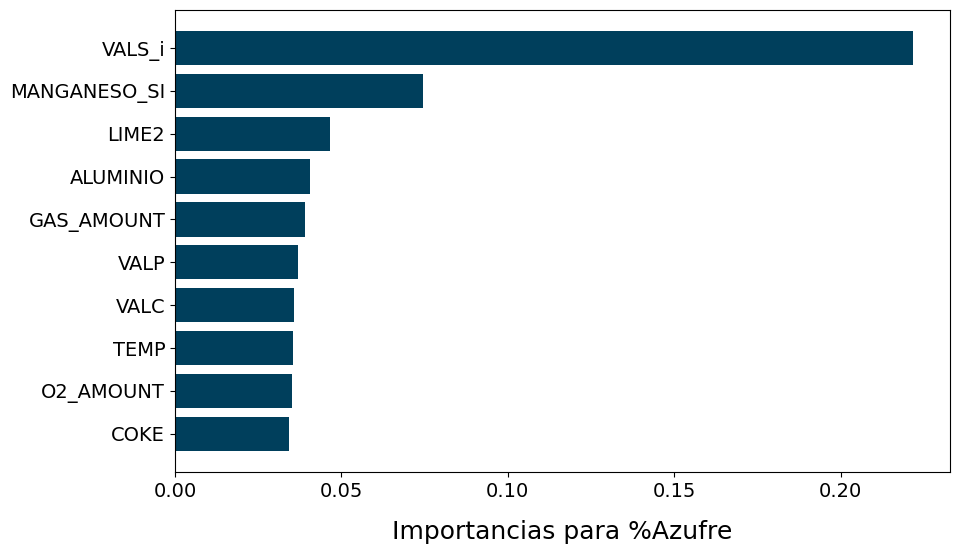

In [467]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': Xnorm.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='#003f5c')
plt.gca().invert_yaxis()  # Invertir el eje para que la más importante esté arriba

plt.xlabel('Importancias para %Azufre', fontsize=18, labelpad=14)
plt.tick_params(axis='both', which='major', labelsize=14)  # Tamaño de las etiquetas
plt.show()

### Modelo Regresión Lineal Múltiple

#### Colinealidad

In [470]:
import numpy as np

# Calculamos la matriz de correlación de Xnorm
correlation_matrix = Xnorm.corr()

# Calculamos el determinante de la matriz de correlación
determinant = np.linalg.det(correlation_matrix)

print(f"Determinante de la matriz de correlación: {determinant}")

Determinante de la matriz de correlación: 0.005837109000773412


In [471]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creamos una tabla para almacenar los VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = Xnorm.columns
vif_data["VIF"] = [variance_inflation_factor(Xnorm.values, i) for i in range(Xnorm.shape[1])]

print(vif_data)

            Variable        VIF
0               VALC   7.758456
1              VALSI   5.776181
2              VALMN  10.945259
3               VALP   4.846926
4             VALS_i   8.832004
5              VALCU  31.977149
6              VALCR   5.785297
7              VALMO   2.036681
8              VALNI   7.627531
9              VALAS  20.115353
10             VALSN  11.012693
11              VALN   1.884854
12              OTRO   2.646334
13             LIME2   1.331140
14  Steelmaking iron   1.612009
15      MANGANESO_SI   1.866036
16          FeSi65-4   1.283217
17       Sulfur wire   1.003721
18              COKE   5.183831
19                3A  29.953140
20          ALUMINIO   1.789560
21         O2_AMOUNT  63.103575
22        GAS_AMOUNT  24.572904
23     CARBON_AMOUNT   1.056847
24         VALO2_PPM   2.649055
25              TEMP  15.513950
26               MWH  14.769387


In [472]:
def eliminar_colineales(Xnorm):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = Xnorm.columns
    vif_data["VIF"] = [variance_inflation_factor(Xnorm.values, i) for i in range(Xnorm.shape[1])]
    
    # Repetimos el proceso hasta que todos los VIF sean <= 8
    while vif_data["VIF"].max() > 8:
        # Encontramos la variable con el VIF más alto
        var_max_vif = vif_data.loc[vif_data["VIF"].idxmax()]
        print(f"Eliminando {var_max_vif['Variable']} con VIF = {var_max_vif['VIF']}")
        
        # Eliminamos la variable con el VIF más alto
        Xnorm = Xnorm.drop(columns=[var_max_vif["Variable"]])
        
        # Recalculamos el VIF con las variables restantes
        vif_data = pd.DataFrame()
        vif_data["Variable"] = Xnorm.columns
        vif_data["VIF"] = [variance_inflation_factor(Xnorm.values, i) for i in range(Xnorm.shape[1])]
    
    # Devolvemos el DataFrame con las variables seleccionadas
    return Xnorm, vif_data

# Llamamos a la función con tu DataFrame Xnorm
Xnorm_final, vif_final = eliminar_colineales(Xnorm)

# Imprimimos las variables restantes y sus VIFs
print("\nVariables restantes y sus VIFs:")
print(vif_final)

Eliminando O2_AMOUNT con VIF = 63.10357527229924
Eliminando VALCU con VIF = 31.92970626157935
Eliminando 3A con VIF = 27.24714327104209
Eliminando VALAS con VIF = 17.624891058972455
Eliminando TEMP con VIF = 14.283537405183244
Eliminando GAS_AMOUNT con VIF = 11.931564032174439
Eliminando MWH con VIF = 10.128658790539715
Eliminando VALMN con VIF = 8.967871263510498

Variables restantes y sus VIFs:
            Variable       VIF
0               VALC  5.763702
1              VALSI  5.451412
2               VALP  4.729562
3             VALS_i  7.949248
4              VALCR  4.310738
5              VALMO  1.829013
6              VALNI  5.647578
7              VALSN  6.946890
8               VALN  1.836490
9               OTRO  2.512143
10             LIME2  1.285288
11  Steelmaking iron  1.330944
12      MANGANESO_SI  1.837478
13          FeSi65-4  1.271852
14       Sulfur wire  1.000963
15              COKE  4.567074
16          ALUMINIO  1.752664
17     CARBON_AMOUNT  1.047745
18         

In [473]:
# Calculamos la matriz de correlación de Xnorm
correlation_matrix = Xnorm_final.corr()

# Calculamos el determinante de la matriz de correlación
determinant = np.linalg.det(correlation_matrix)

print(f"Determinante de la matriz de correlación: {determinant}")

Determinante de la matriz de correlación: 0.08564316335102928


#### Seleccionar variables

In [475]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

svr_model = SVR(kernel='linear')                                  #configurar modelo SVR
rfe_svr = RFE(estimator=svr_model, n_features_to_select=5)       #configurar RFE con SVR
rfe_svr = rfe_svr.fit(Xnorm_final, y)                                            #ajustar

seleccionadas_svr = Xnorm_final.columns[rfe_svr.support_]
print("Variables seleccionadas con SVR:", seleccionadas_svr)

Variables seleccionadas con SVR: Index(['Sulfur wire', 'COKE', 'ALUMINIO', 'CARBON_AMOUNT', 'VALO2_PPM'], dtype='object')


In [476]:
X_selected = Xnorm[seleccionadas_svr]

#### Modelo

In [478]:
from sklearn.linear_model import LinearRegression

# Separa los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Crea el modelo de regresión lineal
model = LinearRegression()

# Entrena el modelo
model.fit(X_train, y_train)

# Realiza predicciones
y_pred = model.predict(X_test)

# Evalúa el modelo
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2}")
print(f"MSE: {mse}")

R²: -15.796153252850527
MSE: 0.0014651559943920393


# 4. EXPORTAR DATOS PARA TABLEAU

In [480]:
trafo_tableau = trafo[['STARTTIME','MWH','Mes','Año']]

In [481]:
trafo_tableau.to_csv('trafo_tableau.csv', index=False)

In [482]:
composicion_tableau = composicion.rename(
    columns={'DATETIME_inicial': 'DATE',
            'VALC_diferencia':'Carbono_C',
            'VALSI_diferencia':'Silicio_Si',
            'VALMN_diferencia':'Manganeso_Mn',
            'VALP_diferencia': 'Fósforo_P',
            'VALS_diferencia': 'Azufre_S',
            'VALCU_diferencia':'Cobre_Cu',
            'VALCR_diferencia':'Cromo_Cr',
            'VALMO_diferencia':'Molibdeno_Mo',
            'VALNI_diferencia':'Niquel_Ni'}
)

In [483]:
composicion_tableau = composicion_tableau[['DATE','Carbono_C','Silicio_Si','Manganeso_Mn','Fósforo_P','Azufre_S','Cobre_Cu','Cromo_Cr','Molibdeno_Mo','Niquel_Ni']]

In [484]:
composicion_tableau.to_csv('composicion_tableau.csv', index=False)

In [485]:
materiasprimas_tableau = pd.merge(
    horno, cesto, on=['HEATID', 'MAT_CODE', 'MAT_DEC','DATETIME'], how='outer'
).merge(
    cesto2,on=['HEATID', 'MAT_CODE','MAT_DEC','DATETIME'], how='outer'
).merge(
    cuchara,left_on=['HEATID', 'MAT_CODE', 'MAT_DEC', 'DATETIME'], right_on=['HEATID', 'MAT_CODE', 'DESCR', 'FILTER_KEY_DATE'], how='outer'
)[['MAT_CODE','MAT_DEC','HEATID','DATETIME','CHARGE_AMOUNT_x','CHARGE_AMOUNT_y','CHARGED_AMOUNT','MAT_CHARGED']]

materiasprimas_tableau['CHARGED_AMOUNT'] = materiasprimas_tableau[['CHARGE_AMOUNT_x','CHARGE_AMOUNT_y','CHARGED_AMOUNT','MAT_CHARGED']].fillna(0).sum(axis=1)
materiasprimas_tableau = materiasprimas_tableau.drop(columns=['CHARGE_AMOUNT_x', 'CHARGE_AMOUNT_y', 'MAT_CHARGED'])
materiasprimas_tableau.head()

,MAT_CODE,MAT_DEC,HEATID,DATETIME,CHARGED_AMOUNT
0,201010,Steelmaking iron,5F0002,2015-01-01 00:51:00,17560.0
1,202007,MnSi17A,5F0002,2015-01-01 01:35:00,723.0
2,202008,FeSi65-4,5F0002,2015-01-01 01:35:00,330.0
3,202034,FeCr025,5F0002,2015-01-01 01:35:00,710.0
4,203068,Coke 10-30 mm,5F0002,2015-01-01 01:02:00,514.0


In [486]:
materiasprimas_tableau.to_csv('materiasprimas_tableau.csv', index=False)